# CSCI 7000 / CMMID - Final Project
- **Author**: Corey Lynn Murphey
- **Professor**: Dan Larremore
- **Deadline**: 10 May 2023


## COVID-19 Aerosol Transmission Estimator, Python Edition

Based on the spreadsheet from: 
- Jimenez, J. L. & Peng, Z. COVID-19 Aerosol Transmission Estimator. https://tinyurl.com/covid-estimator (version : 21-Mar-22).

## Import Libraries

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

### Unit Conversions

In [2]:
sec_per_min = 60
min_per_hour = 60
L_per_m3  = 1000
C_to_Kelvin = 273.15 
ft_per_meter = 3.28084
ft_to_meter = .305 # 1 ft = .305 meters

# Functions -> to use to convert spreadsheet

In [3]:
def netEmissionRate_fx(infectedQuantaExhalationRate, exhalationMaskEfficiency, propPeopleWithMasks, I_0):
    netEmissRate = infectedQuantaExhalationRate * (1 - exhalationMaskEfficiency*propPeopleWithMasks)*I_0 # infectious doses (quanta) h-1
    return netEmissRate

def avgQuantaConcentration_fx(netEmissionRate, firstOrderLossRate, volumeRoom, eventDuration):
    avgQuantaConcentration = netEmissionRate/firstOrderLossRate/volumeRoom*(1-(1/firstOrderLossRate/eventDuration)*(1-np.exp(-firstOrderLossRate*eventDuration))) # infectious doses (quanta) m-3
    return avgQuantaConcentration

def quantaInhaledPerPerson_fx(avgQuantaConcentration, breathingRate, propPeopleWithMasks, inhalationMaskEfficiency, eventDuration):
    quantaInhaledPerPerson = avgQuantaConcentration*breathingRate*eventDuration*(1 - propPeopleWithMasks*inhalationMaskEfficiency) # infectious doses (quanta)
    return quantaInhaledPerPerson

def probabilityOfInfection(quantaInhaledPerPerson):
    #Conditional Results for A GIVEN PERSON & ONE EVENT (assuming number of infected above, typically 1)
    probOfInf = 1 - np.exp(-quantaInhaledPerPerson)
    return probOfInf

def newCases(probOfInf, S_0):
    # Conditional Results for ALL ATTENDEES & ONE EVENT (assuming number of infected above, typically 1
    numNewCases = probOfInf * S_0
    return numNewCases

# Airborne Infection Risk Parameters (From Peng et al., 2022)
def infectionRisk(relBreathingRateFactor, vocalEnhancement, exhalationMaskEfficiency, propPeopleWithMasks, inhalationMaskEfficiency, S_0, volumeRoom, firstOrderLossRate, eventDuration):
    infRiskParam = relBreathingRateFactor * vocalEnhancement * (1-exhalationMaskEfficiency*propPeopleWithMasks)*(1-propPeopleWithMasks*inhalationMaskEfficiency)*eventDuration*S_0/(firstOrderLossRate*volumeRoom)*(1-(1-np.exp(-firstOrderLossRate*eventDuration))/(firstOrderLossRate*eventDuration))
    return infRiskParam

def relInfectionRisk(infRiskParam, S_0):
    relInfRiskParam = infRiskParam/S_0
    return relInfRiskParam

In [4]:
def main(roomParams, envParams, 
                           occupants, eventParams, 
                           breathParams, enhancements, 
                           masking, ventilation, 
                           pathogenParams): 
    lengthRoom, widthRoom, heightRoom = roomParams
    
    floorArea = lengthRoom * widthRoom
    volumeRoom = lengthRoom * widthRoom * heightRoom
    
    #environment
    pressure, temperature, relativeHumidity, backgroundCO2 = envParams
    
    #occupants
    numPeople, I_0, s_0 = occupants 
    S_0 = (numPeople - I_0)*(1 - s_0) #number of susceptible people at time 0
    
    # densities
    density_AreaPerPerson = floorArea/(0.305**2)/numPeople #sq ft / person # TODO : Why hard coded? 
    density_PeoplePerArea = numPeople/floorArea
    density_VolumePerPerson = volumeRoom/numPeople
    
    #breathing
    breathingRate, basicBreathingRate, co2EmissionRate_person = breathParams
    relBreathingRateFactor = breathingRate/basicBreathingRate
    co2EmissionRate_total = co2EmissionRate_person*numPeople*(1/pressure)*(C_to_Kelvin+temperature)/C_to_Kelvin # L/s (@ at actual P & T of room)
    
    #enhancement
    quantaExhalationRate, variantEnhancement, vocalEnhancement = enhancements
    infectedQuantaExhalationRate = quantaExhalationRate * variantEnhancement * vocalEnhancement
    
    #masking
    exhalationMaskEfficiency, propPeopleWithMasks,inhalationMaskEfficiency = masking
    
    #event
    eventDuration_mins, eventRepetitions = eventParams
    eventDuration = eventDuration_mins/min_per_hour # hours

    #ventilation
    ventilationRate, virusDecayRate, depositionRate, additionalControlMeasureRate = ventilation
    
    firstOrderLossRate = ventilationRate + virusDecayRate + depositionRate + additionalControlMeasureRate
    ventilationPerPerson = (volumeRoom * (ventilationRate + additionalControlMeasureRate)/numPeople) # [m^3/hour/person] 
    ventilationPerPerson = ventilationPerPerson*L_per_m3/(sec_per_min * min_per_hour) # [L/s/person]

    # # pathogen, Not yet used
    # probInfective, hospitalizationRate, deathRate = pathogenParams
    
    # -------------- Outputs
    netEmissionRate = netEmissionRate_fx(infectedQuantaExhalationRate, exhalationMaskEfficiency, propPeopleWithMasks, I_0)
    avgQuantaConcentration = avgQuantaConcentration_fx(netEmissionRate, firstOrderLossRate, volumeRoom, eventDuration)
    quantaInhaledPerPerson = quantaInhaledPerPerson_fx(avgQuantaConcentration, breathingRate, propPeopleWithMasks, inhalationMaskEfficiency, eventDuration)

    probOfInf = probabilityOfInfection(quantaInhaledPerPerson)
    numNewCases = newCases(probOfInf, S_0)
    infRiskParam = infectionRisk(relBreathingRateFactor, vocalEnhancement, exhalationMaskEfficiency, propPeopleWithMasks, inhalationMaskEfficiency, S_0, volumeRoom, firstOrderLossRate, eventDuration)
    relInfRiskParam = relInfectionRisk(infRiskParam, S_0)
    
    return netEmissionRate, avgQuantaConcentration, quantaInhaledPerPerson, probOfInf, numNewCases, infRiskParam, relInfRiskParam


# Master Example - Choir
Based on the Skagit Valley Choir

## Parameters

### Room Parameters

In [5]:
lengthRoom = 9.2 # m
widthRoom = 18.3 # m
heightRoom = 4.8 # m 

floorArea = lengthRoom * widthRoom
volumeRoom = lengthRoom * widthRoom * heightRoom

### Environmental Parameters

In [6]:
pressure = 0.95 #atm, Used only for CO2 calculation
temperature = 20 # C, Use web converter if needed for F --> C. Used for CO2 calculation, eventually for survival rate of virus
relativeHumidity = 50 # percentage, Not yet used, but may eventually be used for survival rate of virus
backgroundCO2 = 415 # ppm 

### Occupants

In [7]:
numPeople = 61

# N.B. Modified variable names to correspond with SIR models
I_0 = 1 # number of infected people at time 0
s_0 = 0 # fraction of people susceptible at time 0 
S_0 = (numPeople - I_0)*(1 - s_0) #number of susceptible people at time 0

display(S_0)

density_AreaPerPerson = floorArea/(ft_to_meter**2)/numPeople #sq ft / person 
density_PeoplePerArea = numPeople/floorArea
density_VolumePerPerson = volumeRoom/numPeople

display(density_AreaPerPerson)
display(density_PeoplePerArea)
display(density_VolumePerPerson)

60

29.669443697930664

0.3623188405797102

13.248

#### Breath parameters

In [8]:
breathingRate = 0.026 * min_per_hour #See Readme sheet  - varies a lot with activity level
# as best as I can tell, this comes from a moderate intensity breath rate for people ages 16 - 21
# but I'm not really sure where this number comes from 

basicBreathingRate = 0.0048 * min_per_hour # m3 / h, for a sedentary person in the 41 - 51 age groups (ASSUMPTION)
relBreathingRateFactor = breathingRate/basicBreathingRate

co2EmissionRate_person = 0.0091 # L/s (@ 273 K and 1 atm), From tables in Readme page. This does not affect infection calculation, only use of CO2 as indicator, could ignore
# could be completely incorrect for singing
# if 41-51 age range still applies, this means that the people are doin about 2-3 met of physical activity
co2EmissionRate_total = co2EmissionRate_person*numPeople*(1/pressure)*(C_to_Kelvin+temperature)/C_to_Kelvin # L/s (@ at actual P & T of room)

display(relBreathingRateFactor)
display(co2EmissionRate_total)

5.416666666666666

0.6270992995944007

In [9]:
quantaExhalationRate = 18.6 # infectious doses (quanta) h-1, this is very uncertain
# The 5th and 95th percentiles of the Ep0 values are 8.4 and 48.1 quanta h−1, respectively.(Peng 2022)
variantEnhancement = 1 # Q. enhancement due to variants
vocalEnhancement = 52.15 # Q enhancement due to vocal. & act., Dimensionless (ratio to breathing)
# this value was not cited so I don't know where this came from

infectedQuantaExhalationRate = quantaExhalationRate * variantEnhancement * vocalEnhancement

display(infectedQuantaExhalationRate)

969.99

##### Masking (none in this experiment)

In [10]:
exhalationMaskEfficiency = 0
propPeopleWithMasks = 0
inhalationMaskEfficiency = 0 

### Event Parameters

In [11]:
eventDuration_mins = 150
eventDuration = eventDuration_mins/min_per_hour # hours
eventRepetitions = 1 # if multiple meetings

# ventilation,  ventilation rate of 1 h-1 does not mean that 100% of the air is replaced in 1 h.
ventilationRate = 0.7 # h^-1, this may be low
virusDecayRate = 0.62 # h^-1, from literature. Uncertain parameter
depositionRate = 0.3 # h^-1,  Buonnano et al. (2020), Miller et al. (2020). Could vary 0.24-1.5 h-1, depending on particle size range
additionalControlMeasureRate = 0 # h^-1, E.g. filtering of recirc. air, HEPA air cleaner, UV disinfection, etc. 

# Loss Rate
firstOrderLossRate = ventilationRate + virusDecayRate + depositionRate + additionalControlMeasureRate

In [12]:
ventilationPerPerson = (volumeRoom * (ventilationRate + additionalControlMeasureRate)/numPeople) # [m^3/hour/person] 
ventilationPerPerson = ventilationPerPerson*L_per_m3/(sec_per_min * min_per_hour) # [L/s/person]

display(ventilationPerPerson)

2.5759999999999996

### Pathogen Parameters

For now, for COVID-19...

In [13]:
probInfective =7*2/129200 # %, Very important parameter, specific for each region and time period. For ABSOLUTE results (prob. given prevalence of disease in the population). See Readme sheet
# this is highly dependent on phase of epidemic and region 

hospitalizationRate = 20/100
deathRate = 4/100

# for this example, this is probably an artificially tuned

## Model Outputs (using excel equations rather than functions)

In [14]:
netEmissionRate = infectedQuantaExhalationRate * (1 - exhalationMaskEfficiency*propPeopleWithMasks)*I_0 # infectious doses (quanta) h-1
avgQuantaConcentration = netEmissionRate/firstOrderLossRate/volumeRoom*(1-(1/firstOrderLossRate/eventDuration)*(1-np.exp(-firstOrderLossRate*eventDuration))) # infectious doses (quanta) m-3
quantaInhaledPerPerson = avgQuantaConcentration*breathingRate*eventDuration*(1 - propPeopleWithMasks*inhalationMaskEfficiency) # infectious doses (quanta)

display(netEmissionRate)
display(avgQuantaConcentration)
display(quantaInhaledPerPerson)

#Conditional Results for A GIVEN PERSON & ONE EVENT (assuming number of infected above, typically 1)
probOfInfection = 1 - np.exp(-quantaInhaledPerPerson)
probOfHospitalization = probOfInfection * hospitalizationRate
probOfDeath = probOfInfection * deathRate

display(probOfInfection)
display(probOfHospitalization)
display(probOfDeath)


# Conditional Results for ALL ATTENDEES & ONE EVENT (assuming number of infected above, typically 1

numNewCases = probOfInfection * S_0
numNewHosp = numNewCases * hospitalizationRate
numNewDeaths = numNewCases * deathRate

display(numNewCases)
display(numNewHosp)
display(numNewDeaths)

# Airborne Infection Risk Parameters (From Peng et al., 2022)
#Indicator of risk in terms of OUTBREAK SIZE. Low risk: H<0.05; Med: H<0.5; High: H>0.5; From Peng et al. (2022)
infRiskParam = relBreathingRateFactor * vocalEnhancement * (1-exhalationMaskEfficiency*propPeopleWithMasks)*(1-propPeopleWithMasks*inhalationMaskEfficiency)*eventDuration*S_0/(firstOrderLossRate*volumeRoom)*(1-(1-np.exp(-firstOrderLossRate*eventDuration))/(firstOrderLossRate*eventDuration))

#Indicator of risk in terms of ATTACK RATE. Low risk: Hr< 0.001; Med< 0.01; High>0.01 From Peng et al. (2022)
relInfRiskParam = relBreathingRateFactor *vocalEnhancement * (1-exhalationMaskEfficiency*propPeopleWithMasks)*(1-propPeopleWithMasks*inhalationMaskEfficiency)*eventDuration/(firstOrderLossRate*volumeRoom)*(1-(1-np.exp(-firstOrderLossRate*eventDuration))/(firstOrderLossRate*eventDuration))

display(infRiskParam)
display(relInfRiskParam)

# Results for CO2 as an indicator of risk (not needed for infection estimation, can ignore for simplicity)

avgCO2MixingRat = (co2EmissionRate_total*3.6/ventilationRate/volumeRoom*(1-(1/ventilationRate/eventDuration)*(1-np.exp(-ventilationRate*eventDuration))))*1000000+backgroundCO2
avgCO2Conc = (avgCO2MixingRat - backgroundCO2)*40.9/1000000*44*298/(C_to_Kelvin+temperature)*pressure/1 # TODO : Where do these values come from? 
exhaledCO2Reinhaled_g = avgCO2Conc * eventDuration * breathingRate
exhaledCO2Reinhaled_ppm = (avgCO2MixingRat - backgroundCO2)*eventDuration
exhaledCO2Reinhaled_per = exhaledCO2Reinhaled_ppm/10000 
ratInfExCO2 = probOfInfection/exhaledCO2Reinhaled_per
onePercentInfectionCO2 = (avgCO2MixingRat-backgroundCO2)*eventDuration/1*0.01/probOfInfection+backgroundCO2

display(avgCO2MixingRat)
display(avgCO2Conc)
display(exhaledCO2Reinhaled_g)
display(exhaledCO2Reinhaled_ppm)
display(exhaledCO2Reinhaled_per)
display(ratInfExCO2)
display(onePercentInfectionCO2)


# ABSOLUTE result for ONE EVENT: we use the prevalence of the disease in the community to estimate how many infected people may be present in our event, and calculate results based on that

I_present = (I_0+S_0)*probInfective
display(I_present)

# Absolute results for A GIVEN PERSON & ONE EVENT (using disease prevalence in community)
absProbOfInf = 1 - (1 - probOfInfection * probInfective)**(numPeople-1)
display(absProbOfInf)
absProbOfHosp = absProbOfInf * hospitalizationRate
display(absProbOfHosp)
absProbOfDeath = absProbOfInf * deathRate
display(absProbOfDeath)

# Absolute results for ALL ATTENDEES & ONE EVENT (using disease prevalence in community)
absNumCases = (S_0 - I_present)*absProbOfInf
absNumHosp = absNumCases * hospitalizationRate
absNumDeath = absNumCases * deathRate

display(absNumCases)
display(absNumHosp)
display(absNumDeath)

absOnePercentInfectionCO2 = (avgCO2MixingRat-backgroundCO2)*eventDuration/1*0.01/absProbOfInf+backgroundCO2
display(absOnePercentInfectionCO2)

# ABSOLUTE result for events that are REPEATED MULTIPLE TIMES (e.g. many class meetings during a semester, or a daily commute on public transportation) - Ignore for a single event

compoundProbOfInf = 1-(1-absProbOfInf)**eventRepetitions
compoundProbOfHosp = compoundProbOfInf * hospitalizationRate
compoundProbOfDeath = compoundProbOfInf * deathRate

display(compoundProbOfInf)
display(compoundProbOfHosp)
display(compoundProbOfDeath)

# Absolute results for ALL ATTENDEES & MULTIPLE EVENTS (using disease prevalence in community)
compoundNumCases = (S_0 - I_present)*compoundProbOfInf
compoundNumHosp = compoundNumCases * hospitalizationRate
compoundNumDeath = compoundNumCases * deathRate

display(compoundNumCases)
display(compoundNumHosp)
display(compoundNumDeath)

969.99

0.5611650901148105

2.188543851447761

0.8879201652612078

0.17758403305224157

0.03551680661044831

53.27520991567246

10.655041983134494

2.1310083966268984

24.513259984853953

0.4085543330808991

2521.630081753865

3.6611223000841777

14.27837697032829

5266.575204384662

0.5266575204384663

1.6859536431227147

474.3136118587345

0.0066099071207430336

0.005756500785541019

0.001151300157108204

0.00023026003142164077

0.3453519971969282

0.06907039943938564

0.01381407988787713

9563.917720315552

0.005756500785541019

0.001151300157108204

0.00023026003142164077

0.3453519971969282

0.06907039943938564

0.01381407988787713

# Parameter Sweep Experiments

### Main (calculate baseline emissions for the choir)

In [15]:
roomParams = lengthRoom, widthRoom, heightRoom
envParams = pressure, temperature, relativeHumidity, backgroundCO2 
occupants = numPeople, I_0, s_0
eventParams = eventDuration_mins, eventRepetitions
breathParams = breathingRate, basicBreathingRate, co2EmissionRate_person 
enhancements = quantaExhalationRate, variantEnhancement, vocalEnhancement
masking= exhalationMaskEfficiency, propPeopleWithMasks,inhalationMaskEfficiency
ventilation = ventilationRate, virusDecayRate, depositionRate, additionalControlMeasureRate 
pathogenParams = probInfective, hospitalizationRate, deathRate 

netEmissionRate, avgQuantaConcentration, quantaInhaledPerPerson, probOfInf, numNewCases, infRiskParam, relInfRiskParam = main(roomParams, envParams, occupants, eventParams, breathParams, enhancements, masking, ventilation, pathogenParams)

#### Ventilation

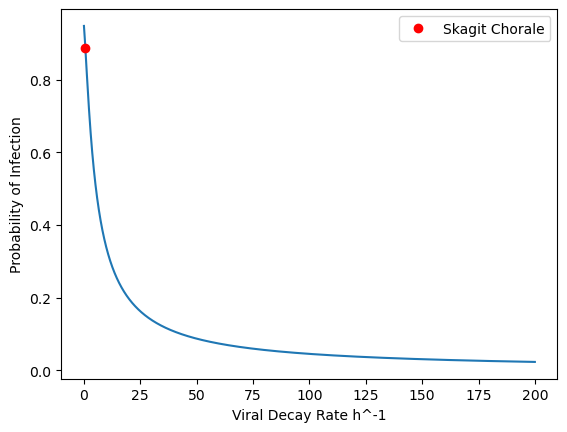

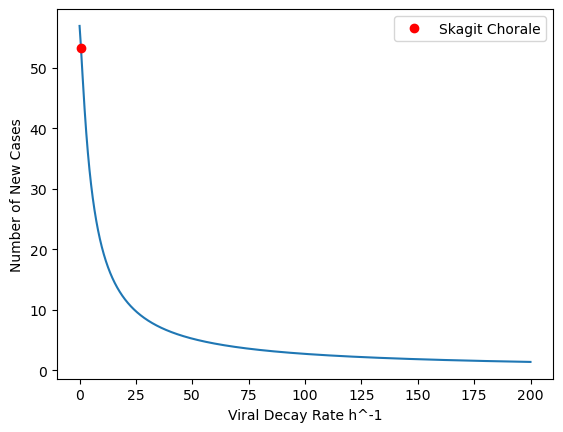

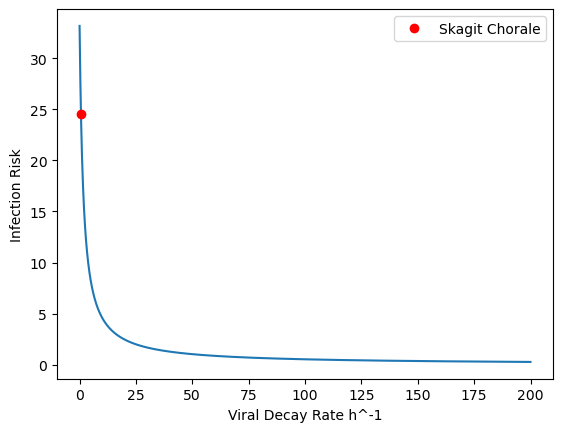

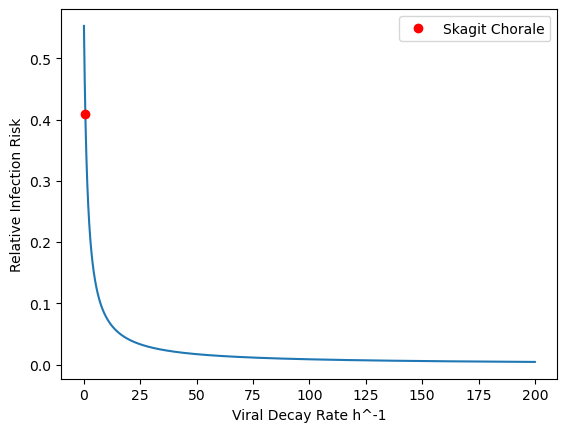

In [16]:
viralDecays = np.arange(0,200,step=0.01) 
netEmissionRates = np.zeros_like(viralDecays)
avgQuantaConcentrations = np.zeros_like(viralDecays)
quantaInhaledPerPersons = np.zeros_like(viralDecays)
probOfInfs = np.zeros_like(viralDecays)
numNewCasess = np.zeros_like(viralDecays)
infRiskParams = np.zeros_like(viralDecays)
relInfRiskParams = np.zeros_like(viralDecays)

for i in range(len(viralDecays)):
    ventilations = ventilationRate, viralDecays[i], depositionRate, additionalControlMeasureRate
    netEmissionRates[i], avgQuantaConcentrations[i], quantaInhaledPerPersons[i], probOfInfs[i], numNewCasess[i], infRiskParams[i], relInfRiskParams[i] = main(
        roomParams, envParams, occupants, eventParams, breathParams, enhancements, masking, ventilations, pathogenParams)


# fig1, ax1 = plt.subplots(1)
# ax1.plot(viralDecays, avgQuantaConcentrations, label = 'viralDecay')
# ax1.plot(virusDecayRate, avgQuantaConcentration, 'ro', label='Skagit Chorale')
# ax1.set_xlabel('Viral Decay Rate h^-1')
# ax1.set_ylabel('avgQuantaConcentrations')
# ax1.legend()

# fig2, ax2 = plt.subplots(1)
# ax2.plot(viralDecays, quantaInhaledPerPersons, label='viralDecay')
# ax2.plot(virusDecayRate, quantaInhaledPerPerson, 'ro', label='Skagit Chorale')
# ax2.set_xlabel('Viral Decay Rate h^-1')
# ax2.set_ylabel('quantaInhaledPerPersons')
# ax2.legend()

fig3, ax3 = plt.subplots(1)
ax3.plot(viralDecays, probOfInfs)
ax3.plot(virusDecayRate, probOfInf, 'ro', label='Skagit Chorale')
ax3.set_xlabel('Viral Decay Rate h^-1')
ax3.set_ylabel('Probability of Infection')
ax3.legend()

fig4, ax4 = plt.subplots(1)
ax4.plot(viralDecays, numNewCasess)
ax4.plot(virusDecayRate, numNewCases, 'ro', label='Skagit Chorale')
ax4.set_xlabel('Viral Decay Rate h^-1')
ax4.set_ylabel('Number of New Cases')
ax4.legend()

fig5, ax5 = plt.subplots(1)
ax5.plot(viralDecays, infRiskParams)
ax5.plot(virusDecayRate, infRiskParam, 'ro', label='Skagit Chorale')
ax5.set_xlabel('Viral Decay Rate h^-1')
ax5.set_ylabel('Infection Risk')
ax5.legend()

fig6, ax6 = plt.subplots(1)
ax6.plot(viralDecays, relInfRiskParams)
ax6.plot(virusDecayRate, relInfRiskParam, 'ro', label='Skagit Chorale')
ax6.set_xlabel('Viral Decay Rate h^-1')
ax6.set_ylabel('Relative Infection Risk')
ax6.legend()



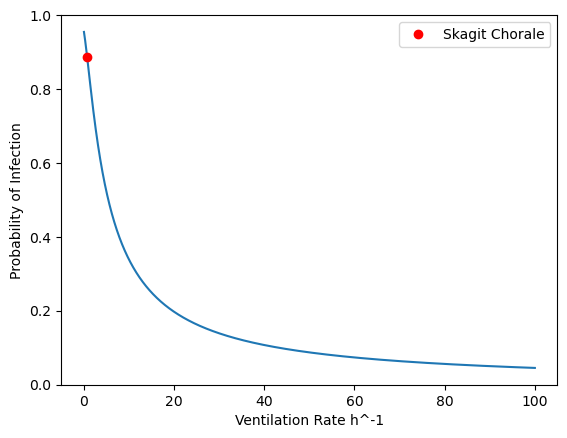

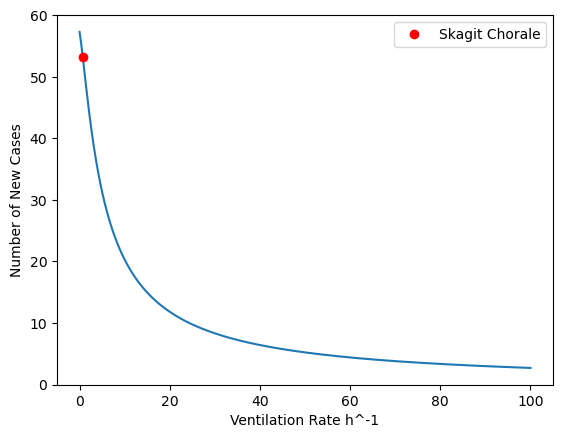

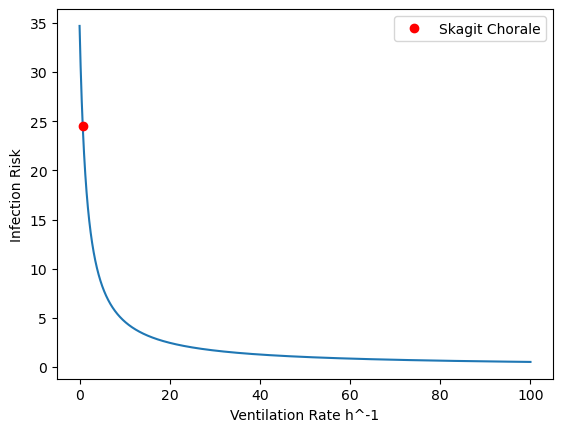

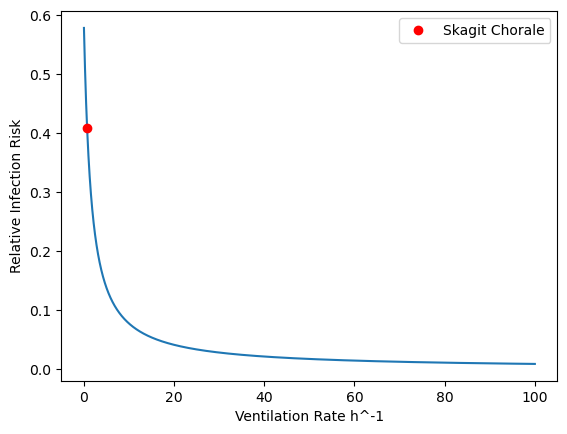

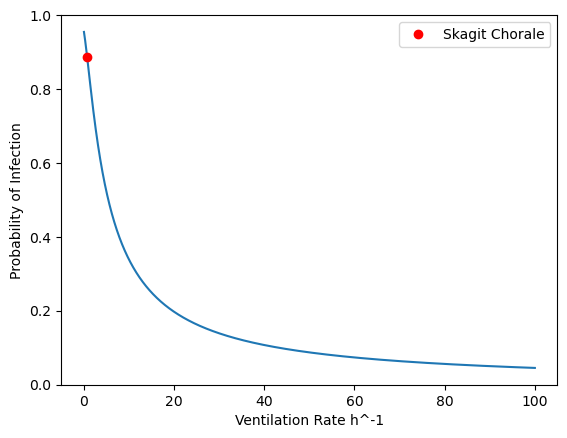

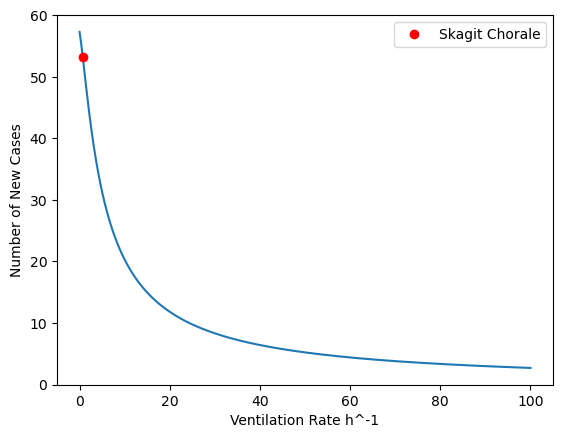

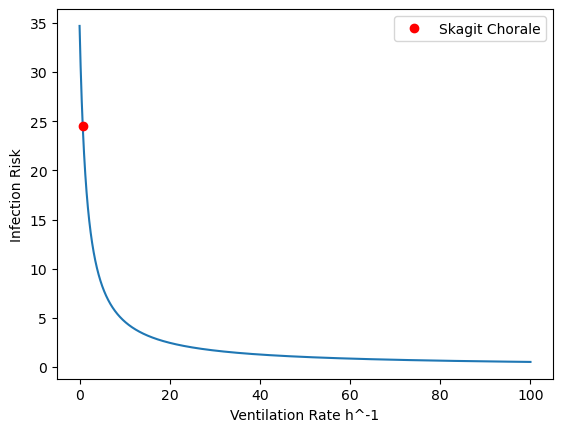

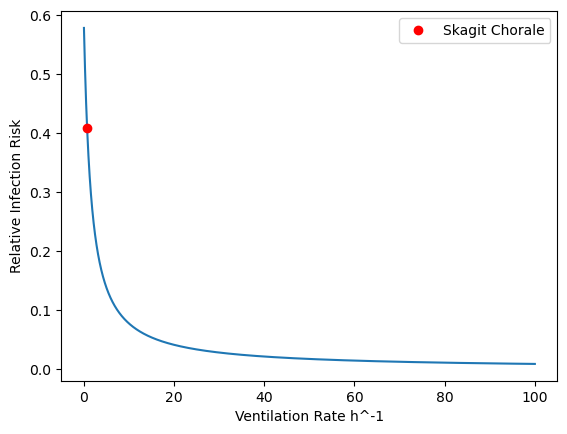

In [17]:
ventilationRates = np.arange(0, 100, step=0.0001)
netEmissionRates = np.zeros_like(ventilationRates)
avgQuantaConcentrations = np.zeros_like(ventilationRates)
quantaInhaledPerPersons = np.zeros_like(ventilationRates)
probOfInfs = np.zeros_like(ventilationRates)
numNewCasess = np.zeros_like(ventilationRates)
infRiskParams = np.zeros_like(ventilationRates)
relInfRiskParams = np.zeros_like(ventilationRates)

for i in range(len(ventilationRates)):
    ventilations = ventilationRates[i], virusDecayRate, depositionRate, additionalControlMeasureRate
    netEmissionRates[i], avgQuantaConcentrations[i], quantaInhaledPerPersons[i], probOfInfs[i], numNewCasess[i], infRiskParams[i], relInfRiskParams[i] = main(
        roomParams, envParams, occupants, eventParams, breathParams, enhancements, masking, ventilations, pathogenParams)


# ax1.plot(ventilationRates, avgQuantaConcentrations)
# ax1.plot(ventilationRate, avgQuantaConcentration, 'ro', label='Skagit Chorale')
# ax1.set_xlabel('Ventilation Rate h^-1')
# ax1.set_ylabel('avgQuantaConcentrations')
# ax1.legend()
# display(fig1)

# ax2.plot(ventilationRates, quantaInhaledPerPersons)
# ax2.plot(ventilationRate, quantaInhaledPerPerson, 'ro', label='Skagit Chorale')
# ax2.set_xlabel('Ventilation Rate h^-1')
# ax2.set_ylabel('quantaInhaledPerPersons')
# ax2.legend()
# display(fig2)

fig3, ax3 = plt.subplots(1)
ax3.plot(ventilationRates, probOfInfs)
ax3.plot(ventilationRate, probOfInf, 'ro', label='Skagit Chorale')
ax3.set_xlabel('Ventilation Rate h^-1')
ax3.set_ylabel('Probability of Infection')
ax3.legend()
display(fig3)

fig4, ax4 = plt.subplots(1)
ax4.plot(ventilationRates, numNewCasess)
ax4.plot(ventilationRate, numNewCases, 'ro', label='Skagit Chorale')
ax4.set_xlabel('Ventilation Rate h^-1')
ax4.set_ylabel('Number of New Cases')
ax4.legend()
display(fig4)

fig5, ax5 = plt.subplots(1)
ax5.plot(ventilationRates, infRiskParams)
ax5.plot(ventilationRate, infRiskParam, 'ro', label='Skagit Chorale')
ax5.set_xlabel('Ventilation Rate h^-1')
ax5.set_ylabel('Infection Risk')
ax5.legend()
display(fig5)

fig6, ax6 = plt.subplots(1)
ax6.plot(ventilationRates, relInfRiskParams)
ax6.plot(ventilationRate, relInfRiskParam, 'ro', label='Skagit Chorale')
ax6.set_xlabel('Ventilation Rate h^-1')
ax6.set_ylabel('Relative Infection Risk')
ax6.legend()
display(fig6)


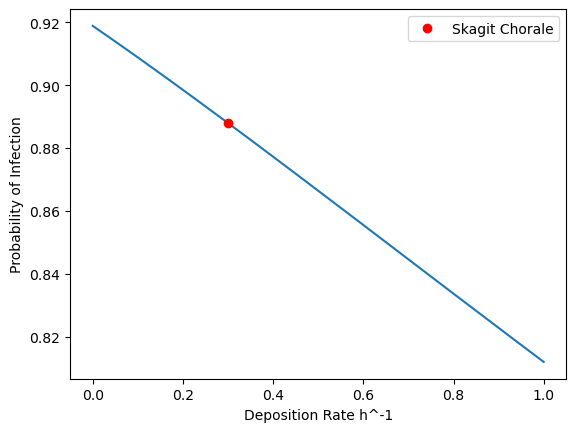

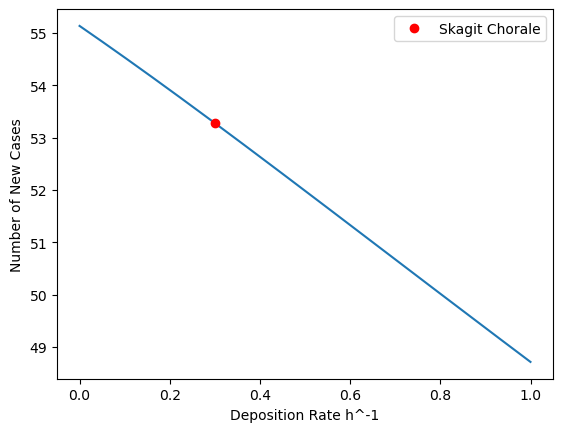

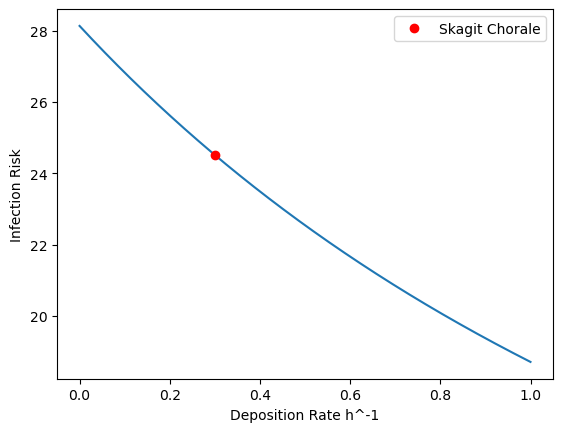

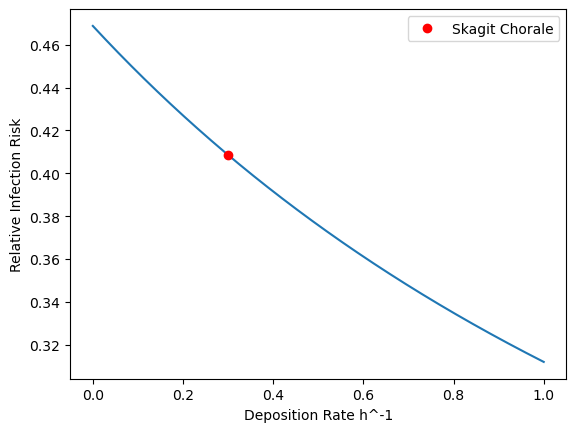

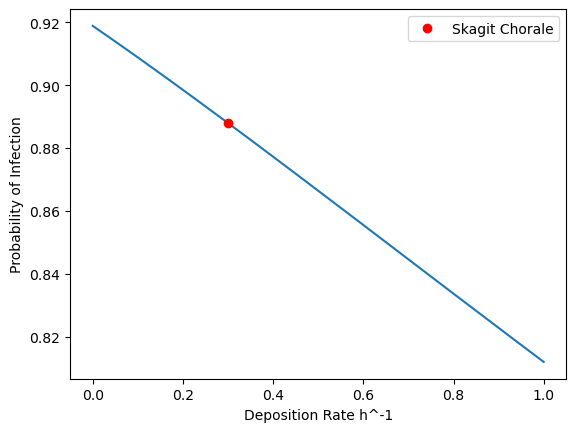

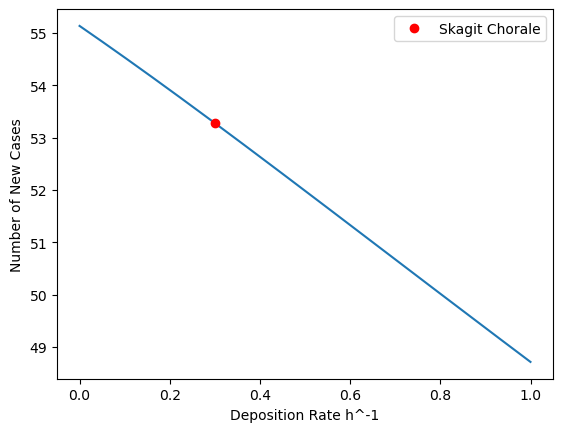

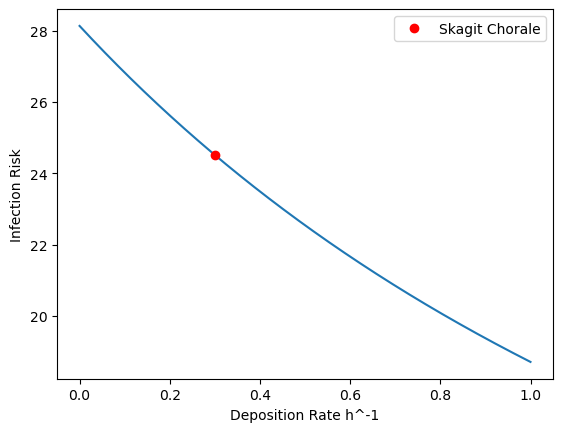

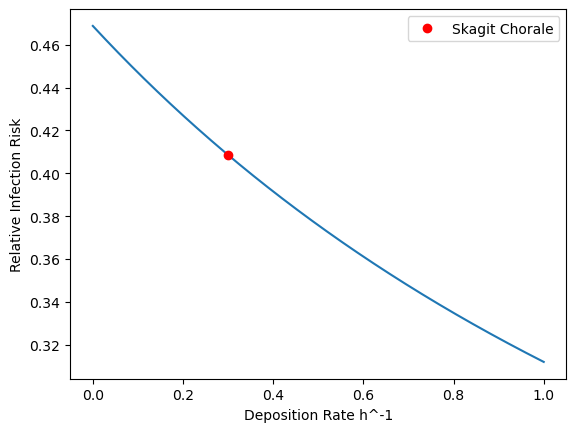

In [18]:
depositionRates = np.arange(0, 1, step=0.0001)
netEmissionRates = np.zeros_like(depositionRates)
avgQuantaConcentrations = np.zeros_like(depositionRates)
quantaInhaledPerPersons = np.zeros_like(depositionRates)
probOfInfs = np.zeros_like(depositionRates)
numNewCasess = np.zeros_like(depositionRates)
infRiskParams = np.zeros_like(depositionRates)
relInfRiskParams = np.zeros_like(depositionRates)

for i in range(len(depositionRates)):
    ventilations = ventilationRate, virusDecayRate, depositionRates[i], additionalControlMeasureRate
    netEmissionRates[i], avgQuantaConcentrations[i], quantaInhaledPerPersons[i], probOfInfs[i], numNewCasess[i], infRiskParams[i], relInfRiskParams[i] = main(
        roomParams, envParams, occupants, eventParams, breathParams, enhancements, masking, ventilations, pathogenParams)


# ax1.plot(depositionRates, avgQuantaConcentrations)
# ax1.plot(depositionRate, avgQuantaConcentration, 'ro', label='Skagit Chorale')
# ax1.set_xlabel('Deposition Rate h^-1')
# ax1.set_ylabel('avgQuantaConcentrations')
# ax1.legend()
# display(fig1)

# ax2.plot(depositionRates, quantaInhaledPerPersons)
# ax2.plot(depositionRate, quantaInhaledPerPerson, 'ro', label='Skagit Chorale')
# ax2.set_xlabel('Deposition Rate h^-1')
# ax2.set_ylabel('quantaInhaledPerPersons')
# ax2.legend()
# display(fig2)

fig3, ax3 = plt.subplots(1)
ax3.plot(depositionRates, probOfInfs)
ax3.plot(depositionRate, probOfInf, 'ro', label='Skagit Chorale')
ax3.set_xlabel('Deposition Rate h^-1')
ax3.set_ylabel('Probability of Infection')
ax3.legend()
display(fig3)

fig4, ax4 = plt.subplots(1)
ax4.plot(depositionRates, numNewCasess)
ax4.plot(depositionRate, numNewCases, 'ro', label='Skagit Chorale')
ax4.set_xlabel('Deposition Rate h^-1')
ax4.set_ylabel('Number of New Cases')
ax4.legend()
display(fig4)

fig5, ax5 = plt.subplots(1)
ax5.plot(depositionRates, infRiskParams)
ax5.plot(depositionRate, infRiskParam, 'ro', label='Skagit Chorale')
ax5.set_xlabel('Deposition Rate h^-1')
ax5.set_ylabel('Infection Risk')
ax5.legend()
display(fig5)

fig6, ax6 = plt.subplots(1)
ax6.plot(depositionRates, relInfRiskParams)
ax6.plot(depositionRate, relInfRiskParam, 'ro', label='Skagit Chorale')
ax6.set_xlabel('Deposition Rate h^-1')
ax6.set_ylabel('Relative Infection Risk')
ax6.legend()
display(fig6)


#### Filtration

In [19]:
def filtration(roomVolume, filterType):
    if filterType == "portable":
        hepaFlowRate = 440 # hard-coded
        addControlMeasure = hepaFlowRate/roomVolume
    elif filterType == "HEPA":
        hepaFlowRate = 260 #cfm
        roomVolume_ft3 = roomVolume * (ft_per_meter)**3
        addControlMeasure = hepaFlowRate/roomVolume_ft3 * sec_per_min
    elif filterType == "recirculated":
        recircFlowRate = 300 #m^3/h
        filterEff = .20
        ductLosses = .1
        addControlMeasure = recircFlowRate / \
            roomVolume * np.min([filterEff, ductLosses])
    else:
        addControlMeasure = 0 

    return addControlMeasure

portable_Filter = filtration(volumeRoom, "portable")
HEPA_Filter = filtration(volumeRoom, "HEPA")
recirculatedAir = filtration(volumeRoom, "recirculated")


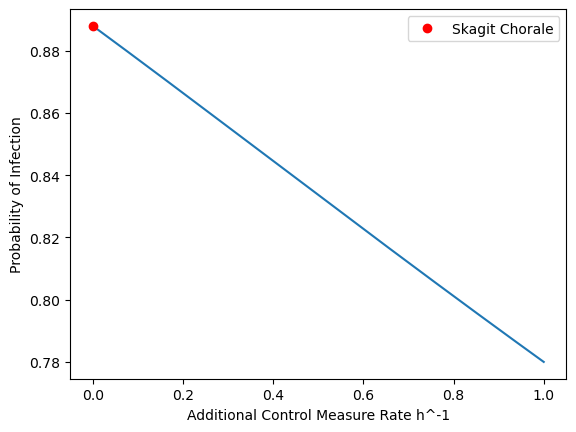

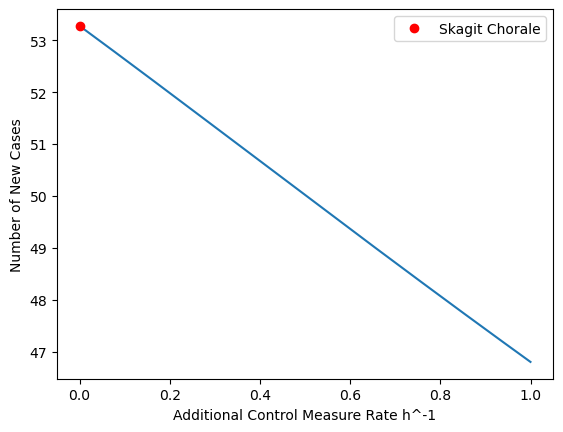

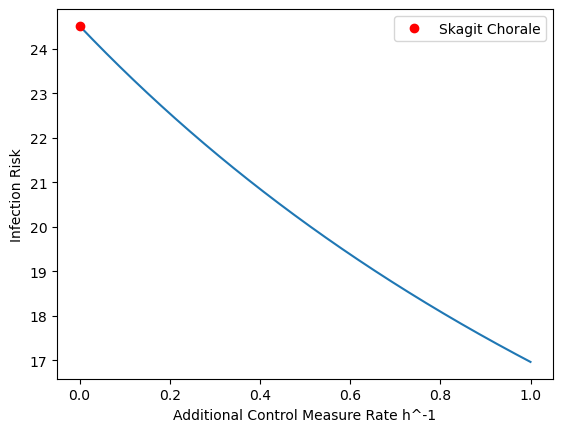

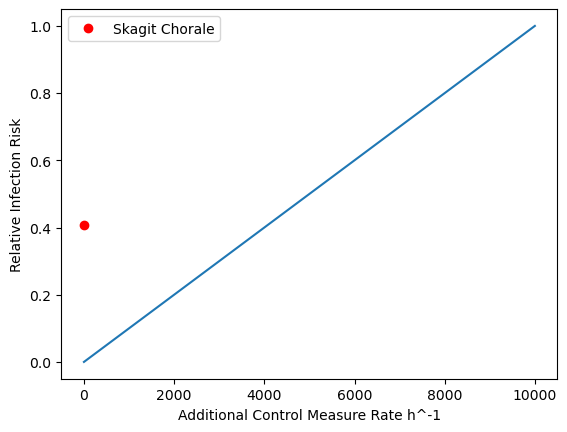

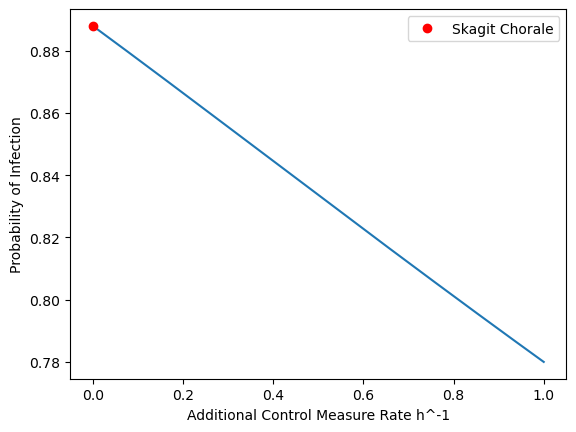

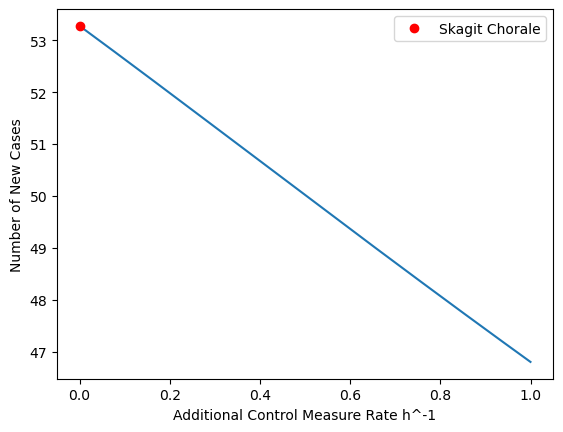

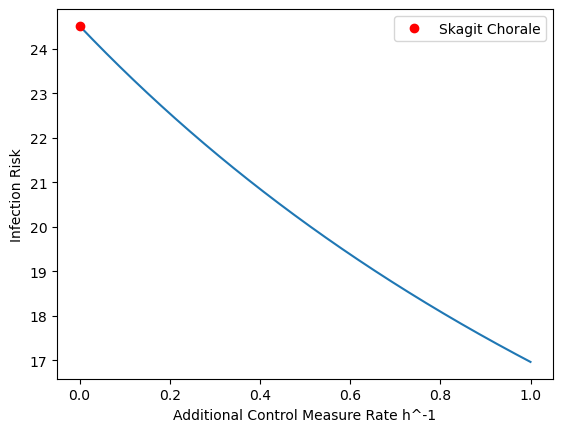

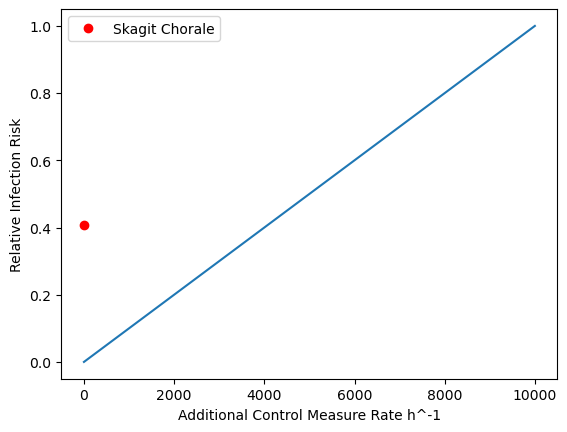

In [20]:
additionalControlMeasureRates = np.arange(0, 1, step=0.0001)
netEmissionRates = np.zeros_like(additionalControlMeasureRates)
avgQuantaConcentrations = np.zeros_like(additionalControlMeasureRates)
quantaInhaledPerPersons = np.zeros_like(additionalControlMeasureRates)
probOfInfs = np.zeros_like(additionalControlMeasureRates)
numNewCasess = np.zeros_like(additionalControlMeasureRates)
infRiskParams = np.zeros_like(additionalControlMeasureRates)
relInfRiskParams = np.zeros_like(additionalControlMeasureRates)

for i in range(len(depositionRates)):
    ventilations = ventilationRate, virusDecayRate, depositionRate, additionalControlMeasureRates[i]
    netEmissionRates[i], avgQuantaConcentrations[i], quantaInhaledPerPersons[i], probOfInfs[i], numNewCasess[i], infRiskParams[i], relInfRiskParams[i] = main(
        roomParams, envParams, occupants, eventParams, breathParams, enhancements, masking, ventilations, pathogenParams)


# ax1.plot(additionalControlMeasureRates,
#          avgQuantaConcentrations, label='additional control measure rates h^-1')
# ax1.plot(additionalControlMeasureRate, avgQuantaConcentration, 'ro', label='Skagit Chorale')
# ax1.vlines(x=[portable_Filter, HEPA_Filter, recirculatedAir], ymin=np.min(avgQuantaConcentrations), ymax=np.max(avgQuantaConcentrations), colors=['g', 'c', 'y'], label=["Portable Filter", "HEPA Filter", "Recirculated Air"])
# ax1.set_xlabel('Additional Control Measure Rate')
# ax1.set_ylabel('avgQuantaConcentrations')
# ax1.legend()
# display(fig1)

# ax2.plot(additionalControlMeasureRates,
#          quantaInhaledPerPersons, label='additional control measure rates h^-1')
# ax2.plot(additionalControlMeasureRate, quantaInhaledPerPerson, 'ro', label='Skagit Chorale')
# # ax2.vlines(x=[portable_Filter, HEPA_Filter, recirculatedAir], ymin=np.min(quantaInhaledPerPersons),
# #            ymax=np.max(quantaInhaledPerPersons), colors=['g', 'c', 'y'], label=["Portable Filter", "HEPA Filter", "Recirculated Air"])
# ax2.set_xlabel('Additional Control Measure Rate')
# ax2.set_ylabel('quantaInhaledPerPersons')
# ax2.legend()
# display(fig2)


fig3, ax3 = plt.subplots(1)
ax3.plot(additionalControlMeasureRates, probOfInfs)
ax3.plot(additionalControlMeasureRate, probOfInf, 'ro', label='Skagit Chorale')
# ax3.vlines(x=[portable_Filter, HEPA_Filter, recirculatedAir], ymin=np.min(probOfInfs),
#            ymax=np.max(probOfInfs), colors=['g', 'c', 'y'], label=["Portable Filter", "HEPA Filter", "Recirculated Air"])
ax3.set_xlabel('Additional Control Measure Rate h^-1')
ax3.set_ylabel('Probability of Infection')
ax3.legend()
display(fig3)

fig4, ax4 = plt.subplots(1)
ax4.plot(additionalControlMeasureRates, numNewCasess)
ax4.plot(additionalControlMeasureRate, numNewCases, 'ro', label='Skagit Chorale')
# ax4.vlines(x=[portable_Filter, HEPA_Filter, recirculatedAir], ymin=np.min(numNewCasess),
#            ymax=np.max(numNewCasess), colors=['g', 'c', 'y'], label=["Portable Filter", "HEPA Filter", "Recirculated Air"])
ax4.set_xlabel('Additional Control Measure Rate h^-1')
ax4.set_ylabel('Number of New Cases')
ax4.legend()
display(fig4)

fig5, ax5 = plt.subplots(1)
ax5.plot(additionalControlMeasureRates, infRiskParams)
ax5.plot(additionalControlMeasureRate, infRiskParam, 'ro', label='Skagit Chorale')
# ax5.vlines(x=[portable_Filter, HEPA_Filter, recirculatedAir], ymin=np.min(infRiskParams),
#            ymax=np.max(infRiskParams), colors=['g', 'c', 'y'], label=["Portable Filter", "HEPA Filter", "Recirculated Air"])
ax5.set_xlabel('Additional Control Measure Rate h^-1')
ax5.set_ylabel('Infection Risk')
ax5.legend()
display(fig5)

fig6, ax6 = plt.subplots(1)
ax6.plot(additionalControlMeasureRates)
ax6.plot(additionalControlMeasureRate, relInfRiskParam, 'ro', label='Skagit Chorale')
# ax6.vlines(x=[portable_Filter, HEPA_Filter, recirculatedAir], ymin=np.min(relInfRiskParams),
#            ymax=np.max(relInfRiskParams), colors=['g', 'c', 'y'], label=["Portable Filter", "HEPA Filter", "Recirculated Air"])
ax6.set_xlabel('Additional Control Measure Rate h^-1')
ax6.set_ylabel('Relative Infection Risk')
ax6.legend()
display(fig6)


### Masking

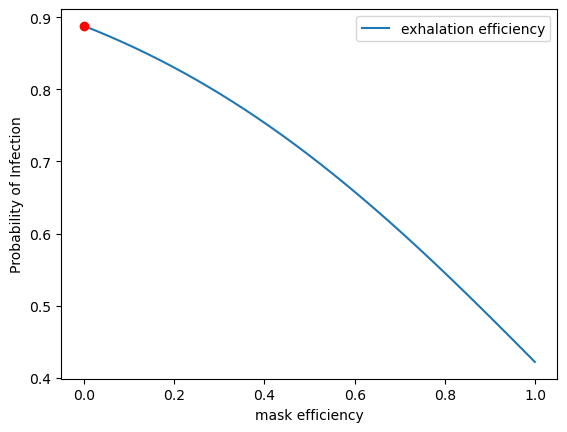

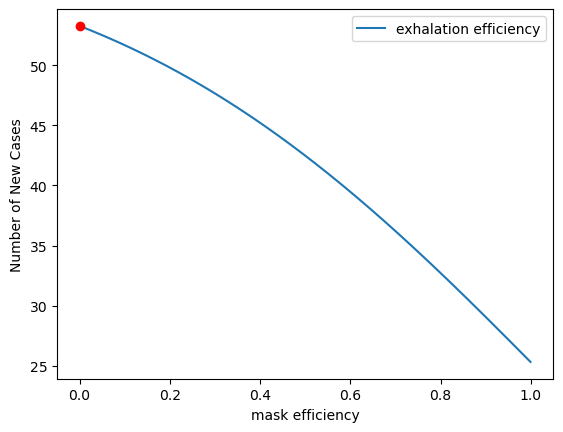

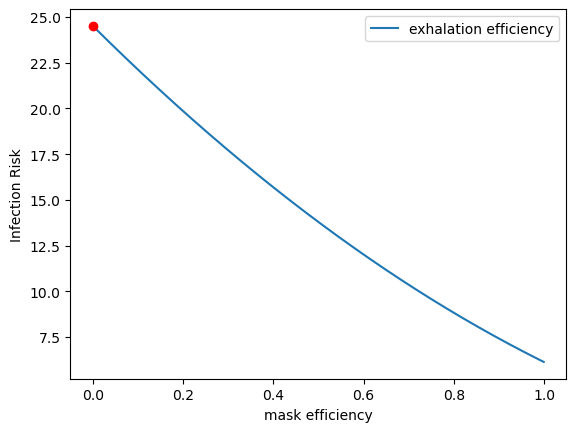

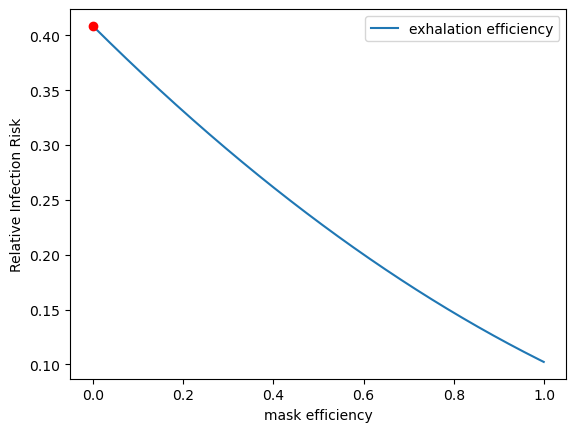

In [21]:
exhalationMaskEfficiencys = np.arange(0,1,step=0.001) 
propPeopleWithMaskss = 0.5
netEmissionRates = np.zeros_like(exhalationMaskEfficiencys)
avgQuantaConcentrations = np.zeros_like(exhalationMaskEfficiencys)
quantaInhaledPerPersons = np.zeros_like(exhalationMaskEfficiencys)
probOfInfs = np.zeros_like(exhalationMaskEfficiencys)
numNewCasess = np.zeros_like(exhalationMaskEfficiencys)
infRiskParams = np.zeros_like(exhalationMaskEfficiencys)
relInfRiskParams = np.zeros_like(exhalationMaskEfficiencys)

# fig1, ax1 = plt.subplots(1)
# fig2, ax2 = plt.subplots(1)
fig3, ax3 = plt.subplots(1)
fig4, ax4 = plt.subplots(1)
fig5, ax5 = plt.subplots(1)
fig6, ax6 = plt.subplots(1)


for i in range(len(exhalationMaskEfficiencys)):

        inhalationMaskEfficiencys = exhalationMaskEfficiencys[i]
        maskings = exhalationMaskEfficiencys[i], propPeopleWithMaskss, inhalationMaskEfficiencys 
        netEmissionRates[i], avgQuantaConcentrations[i], quantaInhaledPerPersons[i], probOfInfs[i], numNewCasess[i], infRiskParams[i], relInfRiskParams[i] = main(
                roomParams, envParams, occupants, eventParams, breathParams, enhancements, maskings, ventilation, pathogenParams)


# ax1.plot(exhalationMaskEfficiencys,
#         avgQuantaConcentrations, label='exhalation efficiency')
# ax1.plot(exhalationMaskEfficiency, avgQuantaConcentration, 'ro', label='Skagit Chorale')
# # ax1.set_xlabel('mask efficiency')
# ax1.set_ylabel('avgQuantaConcentrations')
# ax1.legend()

# ax2.plot(exhalationMaskEfficiencys,
#         quantaInhaledPerPersons, label='exhalation efficiency')
# ax2.plot(exhalationMaskEfficiency, quantaInhaledPerPerson, 'ro', label='Skagit Chorale')
# # ax2.set_xlabel('mask efficiency')
# ax2.set_ylabel('quantaInhaledPerPersons')
# ax2.legend()

ax3.plot(exhalationMaskEfficiencys, probOfInfs,
        label='exhalation efficiency')
ax3.plot(exhalationMaskEfficiency, probOfInf, 'ro')
ax3.set_xlabel('mask efficiency')
ax3.set_ylabel('Probability of Infection')
ax3.legend()

ax4.plot(exhalationMaskEfficiencys, numNewCasess,
        label='exhalation efficiency')
ax4.plot(exhalationMaskEfficiency, numNewCases, 'ro')
ax4.set_xlabel('mask efficiency')
ax4.set_ylabel('Number of New Cases')
ax4.legend()

ax5.plot(exhalationMaskEfficiencys, infRiskParams,
        label='exhalation efficiency')
ax5.plot(exhalationMaskEfficiency, infRiskParam, 'ro')
ax5.set_xlabel('mask efficiency')
ax5.set_ylabel('Infection Risk')
ax5.legend()

ax6.plot(exhalationMaskEfficiencys, relInfRiskParams,
        label='exhalation efficiency')
ax6.plot(exhalationMaskEfficiency, relInfRiskParam, 'ro')
ax6.set_xlabel('mask efficiency')
ax6.set_ylabel('Relative Infection Risk')
ax6.legend()



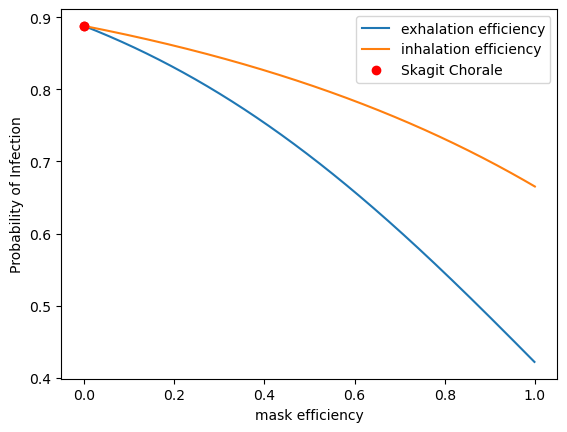

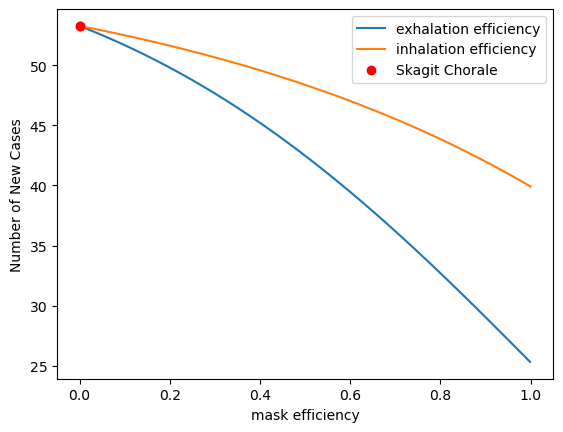

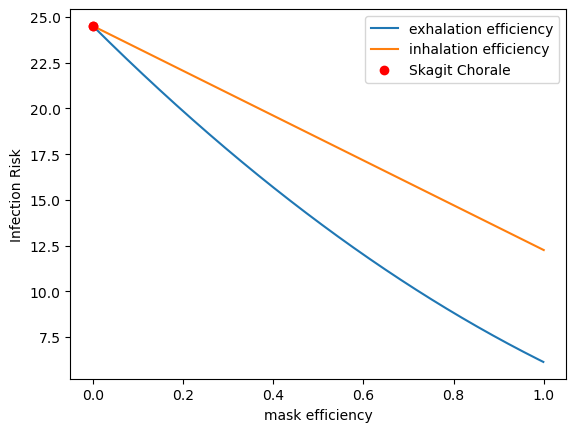

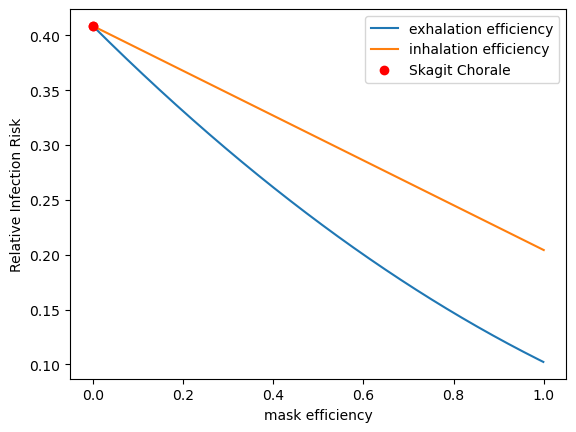

In [22]:
inhalationMaskEfficiencys = np.arange(0, 1, step=0.0001)
propPeopleWithMaskss = 0.5
netEmissionRates = np.zeros_like(inhalationMaskEfficiencys)
avgQuantaConcentrations = np.zeros_like(inhalationMaskEfficiencys)
quantaInhaledPerPersons = np.zeros_like(inhalationMaskEfficiencys)
probOfInfs = np.zeros_like(inhalationMaskEfficiencys)
numNewCasess = np.zeros_like(inhalationMaskEfficiencys)
infRiskParams = np.zeros_like(inhalationMaskEfficiencys)
relInfRiskParams = np.zeros_like(inhalationMaskEfficiencys)

for i in range(len(inhalationMaskEfficiencys)):
    exhalationMaskEfficiencys = inhalationMaskEfficiencys[i]
    maskings = exhalationMaskEfficiency, propPeopleWithMaskss, inhalationMaskEfficiencys[i] 
    netEmissionRates[i], avgQuantaConcentrations[i], quantaInhaledPerPersons[i], probOfInfs[i], numNewCasess[i], infRiskParams[i], relInfRiskParams[i] = main(
            roomParams, envParams, occupants, eventParams, breathParams, enhancements, maskings, ventilation, pathogenParams)


# ax1.plot(inhalationMaskEfficiencys,
#          avgQuantaConcentrations, label='inhalation efficiency')
# ax1.plot(inhalationMaskEfficiency, avgQuantaConcentration, 'ro', label='Skagit Chorale')
# # ax1.set_xlabel('mask efficiency')
# ax1.set_ylabel('avgQuantaConcentrations')
# ax1.legend()
# display(fig1)

# ax2.plot(inhalationMaskEfficiencys,
#          quantaInhaledPerPersons, label='inhalation efficiency')
# ax2.plot(inhalationMaskEfficiency, quantaInhaledPerPerson, 'ro', label='Skagit Chorale')
# # ax2.set_xlabel('mask efficiency')
# ax2.set_ylabel('quantaInhaledPerPersons')
# ax2.legend()
# display(fig2)


ax3.plot(inhalationMaskEfficiencys, probOfInfs,
         label='inhalation efficiency')
ax3.plot(inhalationMaskEfficiency, probOfInf, 'ro', label='Skagit Chorale')
ax3.set_xlabel('mask efficiency')
ax3.set_ylabel('Probability of Infection')
ax3.legend()
display(fig3)


ax4.plot(inhalationMaskEfficiencys, numNewCasess,
         label='inhalation efficiency')
ax4.plot(inhalationMaskEfficiency, numNewCases, 'ro', label='Skagit Chorale')
ax4.set_xlabel('mask efficiency')
ax4.set_ylabel('Number of New Cases')
ax4.legend()
display(fig4)


ax5.plot(inhalationMaskEfficiencys, infRiskParams,
         label='inhalation efficiency')
ax5.plot(inhalationMaskEfficiency, infRiskParam, 'ro', label='Skagit Chorale')
ax5.set_xlabel('mask efficiency')
ax5.set_ylabel('Infection Risk')
ax5.legend()
display(fig5)


ax6.plot(inhalationMaskEfficiencys, relInfRiskParams,
         label='inhalation efficiency')
ax6.plot(inhalationMaskEfficiency, relInfRiskParam, 'ro', label='Skagit Chorale')
ax6.set_xlabel('mask efficiency')
ax6.set_ylabel('Relative Infection Risk')
ax6.legend()
display(fig6)


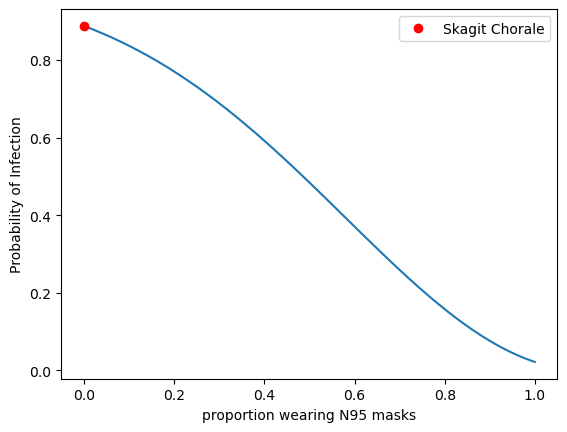

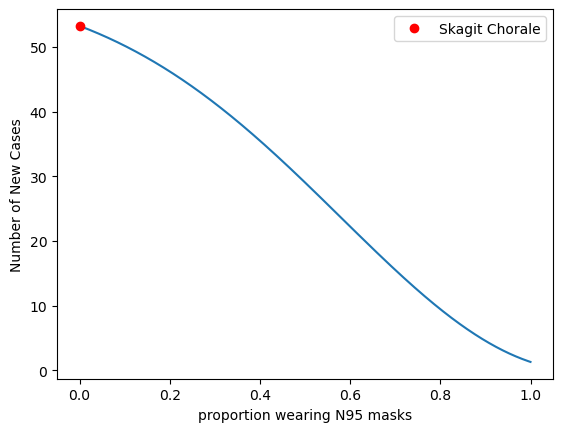

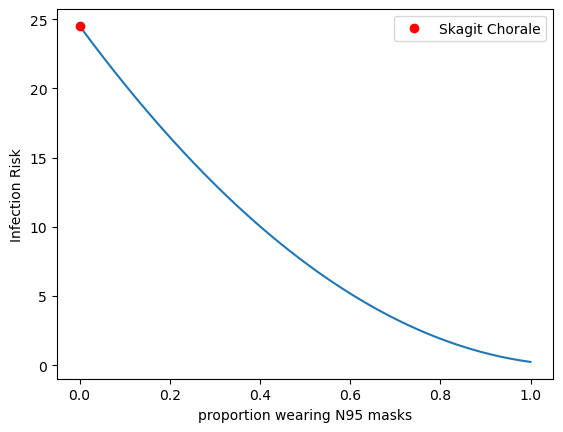

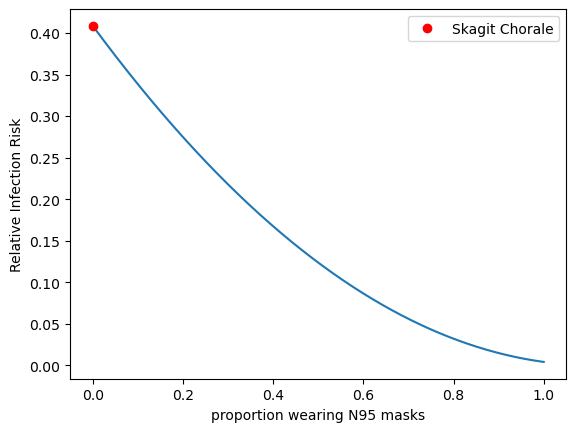

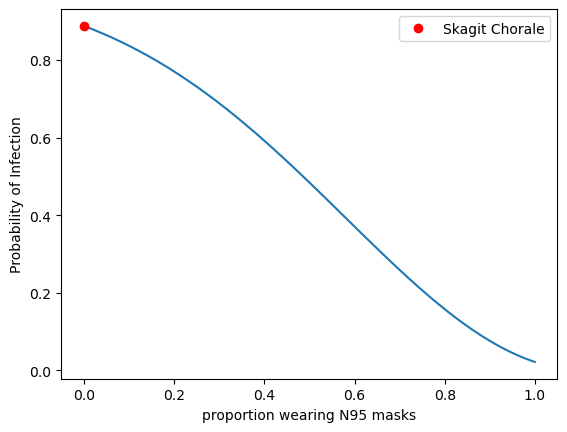

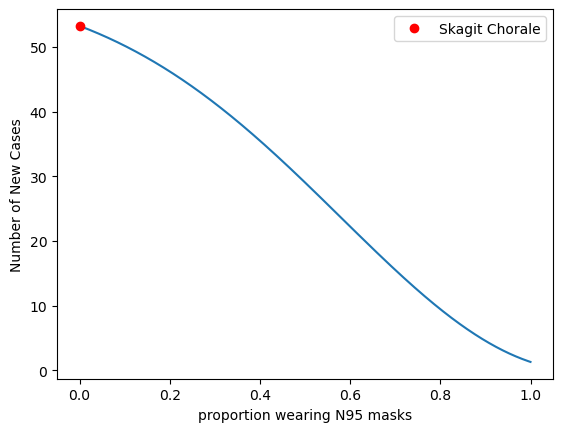

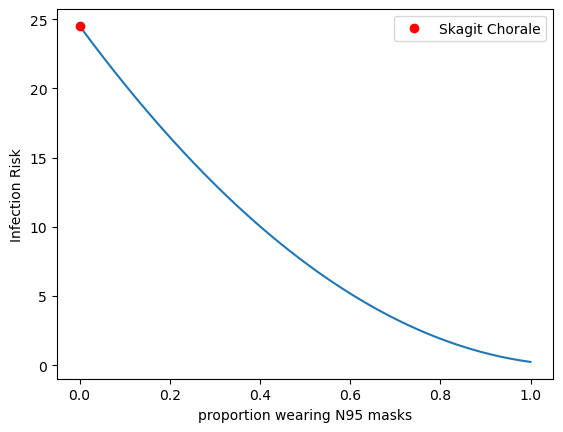

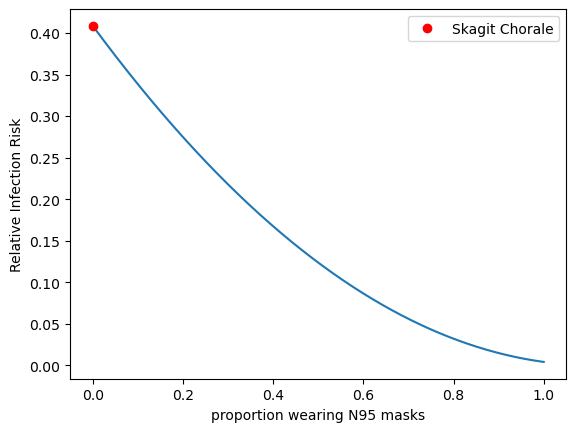

In [23]:
propPeopleWithMaskss = np.arange(0, 1, step=0.0001)
exhalationMaskEfficiencys = 0.9 # assumes everyone wearing N95/KN95
netEmissionRates = np.zeros_like(propPeopleWithMaskss)
avgQuantaConcentrations = np.zeros_like(propPeopleWithMaskss)
quantaInhaledPerPersons = np.zeros_like(propPeopleWithMaskss)
probOfInfs = np.zeros_like(propPeopleWithMaskss)
numNewCasess = np.zeros_like(propPeopleWithMaskss)
infRiskParams = np.zeros_like(propPeopleWithMaskss)
relInfRiskParams = np.zeros_like(propPeopleWithMaskss)

# fig1, ax1 = plt.subplots(1)
# fig2, ax2 = plt.subplots(1)
fig3, ax3 = plt.subplots(1)
fig4, ax4 = plt.subplots(1)
fig5, ax5 = plt.subplots(1)
fig6, ax6 = plt.subplots(1)

for i in range(len(propPeopleWithMaskss)):
    inhalationMaskEfficiencys = exhalationMaskEfficiencys
    maskings = exhalationMaskEfficiencys, propPeopleWithMaskss[i], inhalationMaskEfficiencys 
    netEmissionRates[i], avgQuantaConcentrations[i], quantaInhaledPerPersons[i], probOfInfs[i], numNewCasess[i], infRiskParams[i], relInfRiskParams[i] = main(
            roomParams, envParams, occupants, eventParams, breathParams, enhancements, maskings, ventilation, pathogenParams)


# ax1.plot(propPeopleWithMaskss,
#          avgQuantaConcentrations, label='propPeopleWithMaskss')
# ax1.plot(propPeopleWithMasks, avgQuantaConcentration, 'ro', label='Skagit Chorale')
# # ax1.set_xlabel('proportion wearing N95 masks')
# ax1.set_ylabel('avgQuantaConcentrations')
# ax1.legend()
# display(fig1)

# ax2.plot(propPeopleWithMaskss,
#          quantaInhaledPerPersons, label='propPeopleWithMaskss')
# ax2.plot(propPeopleWithMasks, quantaInhaledPerPerson, 'ro', label='Skagit Chorale')
# # ax2.set_xlabel('proportion wearing N95 masks')
# ax2.set_ylabel('quantaInhaledPerPersons')
# ax2.legend()
# display(fig2)

ax3.plot(propPeopleWithMaskss, probOfInfs)
ax3.plot(propPeopleWithMasks, probOfInf, 'ro', label='Skagit Chorale')
ax3.set_xlabel('proportion wearing N95 masks')
ax3.set_ylabel('Probability of Infection')
ax3.legend()
display(fig3)


ax4.plot(propPeopleWithMaskss, numNewCasess)
ax4.plot(propPeopleWithMasks, numNewCases, 'ro', label='Skagit Chorale')
ax4.set_xlabel('proportion wearing N95 masks')
ax4.set_ylabel('Number of New Cases')
ax4.legend()
display(fig4)


ax5.plot(propPeopleWithMaskss, infRiskParams)
ax5.plot(propPeopleWithMasks, infRiskParam, 'ro', label='Skagit Chorale')
ax5.set_xlabel('proportion wearing N95 masks')
ax5.set_ylabel('Infection Risk')
ax5.legend()
display(fig5)


ax6.plot(propPeopleWithMaskss, relInfRiskParams)
ax6.plot(propPeopleWithMasks, relInfRiskParam, 'ro', label='Skagit Chorale')
ax6.set_xlabel('proportion wearing N95 masks')
ax6.set_ylabel('Relative Infection Risk')
ax6.legend()
display(fig6)

### Infection Risk

#### Infection Risk vs. Room size

Text(0, 0.5, 'Infection Risk')

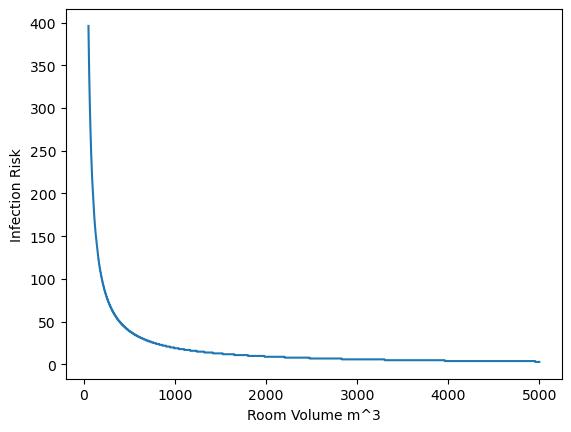

In [24]:
roomVolumes = np.arange(50,5000) # m^3
infRisk = np.zeros_like(roomVolumes)

for i in range(len(roomVolumes)): 
    infRisk[i] = infectionRisk(relBreathingRateFactor, vocalEnhancement, exhalationMaskEfficiency, propPeopleWithMasks, inhalationMaskEfficiency, S_0, roomVolumes[i], firstOrderLossRate, eventDuration)

fig, ax = plt.subplots(1)
ax.plot(roomVolumes,infRisk)
ax.set_xlabel('Room Volume m^3')
ax.set_ylabel('Infection Risk')


### Infections over time

/var/folders/15/s8ldr64x50q5znqbr6dxz1tc0000gp/T/ipykernel_30499/1845653639.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  avgQuantaConcentration = netEmissionRate/firstOrderLossRate/volumeRoom*(1-(1/firstOrderLossRate/eventDuration)*(1-np.exp(-firstOrderLossRate*eventDuration))) # infectious doses (quanta) m-3
/var/folders/15/s8ldr64x50q5znqbr6dxz1tc0000gp/T/ipykernel_30499/1845653639.py:6: RuntimeWarning: invalid value encountered in scalar multiply
  avgQuantaConcentration = netEmissionRate/firstOrderLossRate/volumeRoom*(1-(1/firstOrderLossRate/eventDuration)*(1-np.exp(-firstOrderLossRate*eventDuration))) # infectious doses (quanta) m-3
/var/folders/15/s8ldr64x50q5znqbr6dxz1tc0000gp/T/ipykernel_30499/1845653639.py:25: RuntimeWarning: invalid value encountered in scalar divide
  infRiskParam = relBreathingRateFactor * vocalEnhancement * (1-exhalationMaskEfficiency*propPeopleWithMasks)*(1-propPeopleWithMasks*inhalationMaskEfficiency)*eventDuration*S_0/(firstOrderL

0.9999999999981664

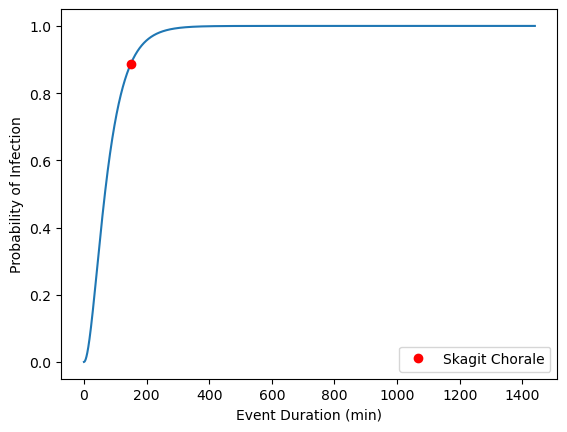

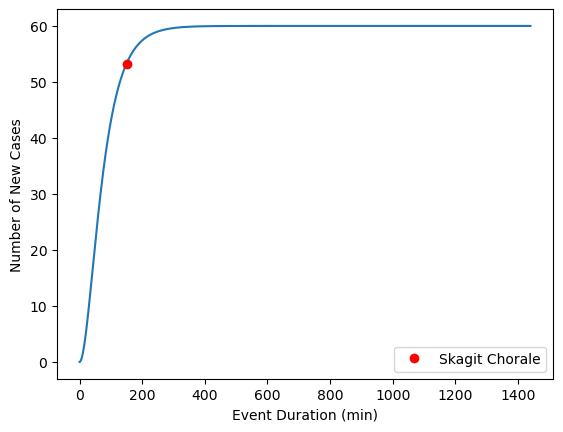

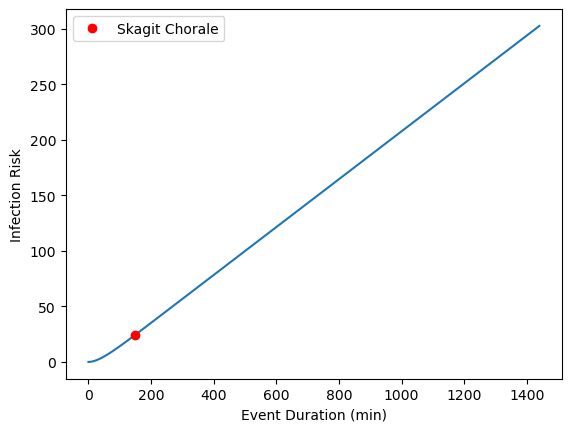

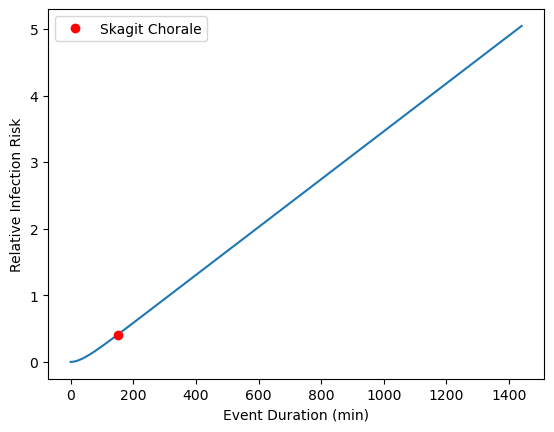

In [25]:
eventDuration_minss = np.arange(0,24*60,step = .1)

netEmissionRates = np.zeros_like(eventDuration_minss)
avgQuantaConcentrations = np.zeros_like(eventDuration_minss)
quantaInhaledPerPersons = np.zeros_like(eventDuration_minss)
probOfInfs = np.zeros_like(eventDuration_minss)
numNewCasess = np.zeros_like(eventDuration_minss)
infRiskParams = np.zeros_like(eventDuration_minss)
relInfRiskParams = np.zeros_like(eventDuration_minss)

for i in range(len(eventDuration_minss)):
    eventParamss = eventDuration_minss[i], eventRepetitions
    netEmissionRates[i], avgQuantaConcentrations[i], quantaInhaledPerPersons[i], probOfInfs[i], numNewCasess[i], infRiskParams[i], relInfRiskParams[i] = main(
            roomParams, envParams, occupants, eventParamss, breathParams, enhancements, masking, ventilation, pathogenParams)


# fig1, ax1 = plt.subplots(1)
# ax1.plot(eventDuration_minss, avgQuantaConcentrations, label = 'eventDuration_minss')
# ax1.plot(eventDuration_mins, avgQuantaConcentration, 'ro', label='Skagit Chorale')
# ax1.set_xlabel('Event Duration (min)')
# ax1.set_ylabel('avgQuantaConcentrations')
# ax1.legend()

# fig2, ax2 = plt.subplots(1)
# ax2.plot(eventDuration_minss, quantaInhaledPerPersons, label='eventDuration_minss')
# ax2.plot(eventDuration_mins, quantaInhaledPerPerson, 'ro', label='Skagit Chorale')
# ax2.set_xlabel('Event Duration (min)')
# ax2.set_ylabel('quantaInhaledPerPersons')
# ax2.legend()

fig3, ax3 = plt.subplots(1)
ax3.plot(eventDuration_minss, probOfInfs)
ax3.plot(eventDuration_mins, probOfInf, 'ro', label='Skagit Chorale')
peak_probOfInf = np.nanmax(probOfInfs)
display(peak_probOfInf)
ax3.set_xlabel('Event Duration (min)')
ax3.set_ylabel('Probability of Infection')
ax3.legend()

fig4, ax4 = plt.subplots(1)
ax4.plot(eventDuration_minss, numNewCasess)
ax4.plot(eventDuration_mins, numNewCases, 'ro', label='Skagit Chorale')
ax4.set_xlabel('Event Duration (min)')
ax4.set_ylabel('Number of New Cases')
ax4.legend()

fig5, ax5 = plt.subplots(1)
ax5.plot(eventDuration_minss, infRiskParams)
ax5.plot(eventDuration_mins, infRiskParam, 'ro', label='Skagit Chorale')
ax5.set_xlabel('Event Duration (min)')
ax5.set_ylabel('Infection Risk')
ax5.legend()

fig6, ax6 = plt.subplots(1)
ax6.plot(eventDuration_minss, relInfRiskParams)
ax6.plot(eventDuration_mins, relInfRiskParam, 'ro', label='Skagit Chorale')
ax6.set_xlabel('Event Duration (min)')
ax6.set_ylabel('Relative Infection Risk')
ax6.legend()

#### Masking

/var/folders/15/s8ldr64x50q5znqbr6dxz1tc0000gp/T/ipykernel_30499/1845653639.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  avgQuantaConcentration = netEmissionRate/firstOrderLossRate/volumeRoom*(1-(1/firstOrderLossRate/eventDuration)*(1-np.exp(-firstOrderLossRate*eventDuration))) # infectious doses (quanta) m-3
/var/folders/15/s8ldr64x50q5znqbr6dxz1tc0000gp/T/ipykernel_30499/1845653639.py:6: RuntimeWarning: invalid value encountered in scalar multiply
  avgQuantaConcentration = netEmissionRate/firstOrderLossRate/volumeRoom*(1-(1/firstOrderLossRate/eventDuration)*(1-np.exp(-firstOrderLossRate*eventDuration))) # infectious doses (quanta) m-3
/var/folders/15/s8ldr64x50q5znqbr6dxz1tc0000gp/T/ipykernel_30499/1845653639.py:25: RuntimeWarning: invalid value encountered in scalar divide
  infRiskParam = relBreathingRateFactor * vocalEnhancement * (1-exhalationMaskEfficiency*propPeopleWithMasks)*(1-propPeopleWithMasks*inhalationMaskEfficiency)*eventDuration*S_0/(firstOrderL

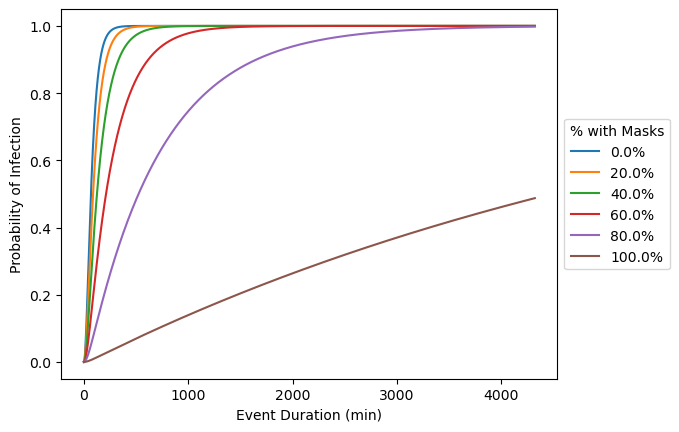

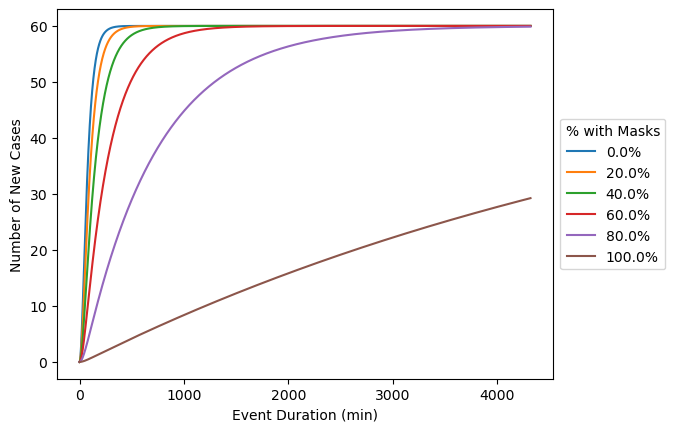

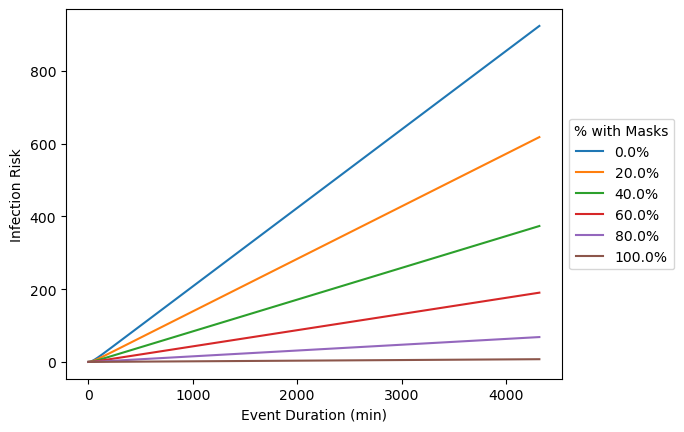

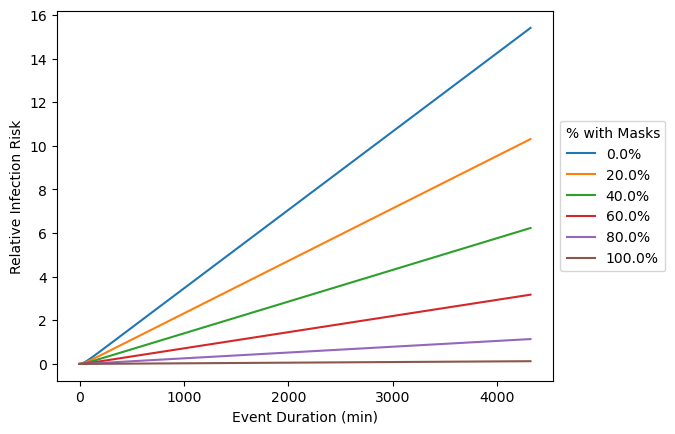

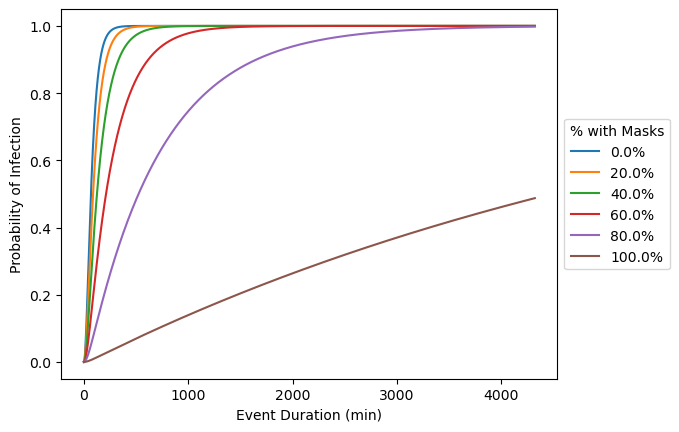

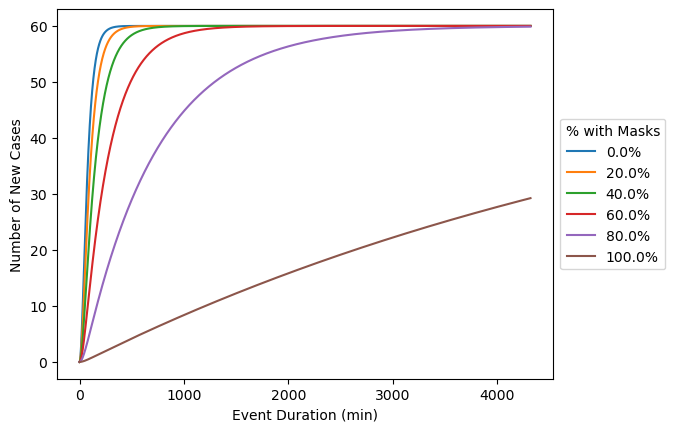

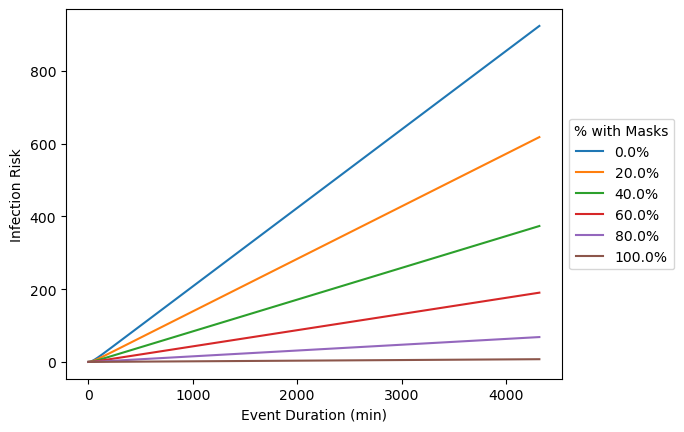

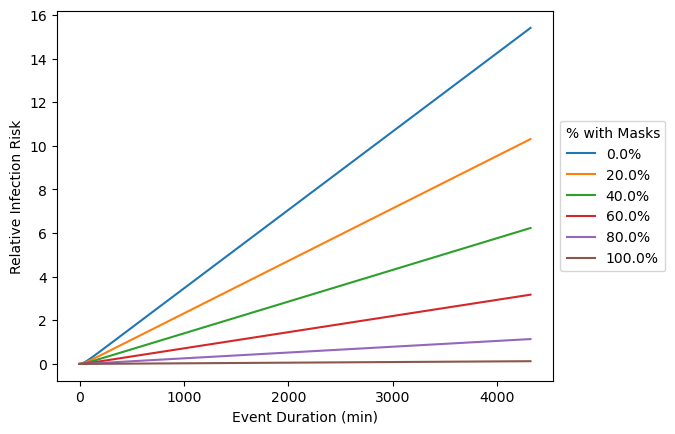

In [26]:
eventDuration_minss = np.arange(0,72*60,step = .1)
propPeopleWithMaskss = np.arange(0.00,1.01,step = .20)
inhalationMaskEfficiency = 0.91
exhalationMaskEfficiency = inhalationMaskEfficiency

netEmissionRates = np.zeros_like(eventDuration_minss)
avgQuantaConcentrations = np.zeros_like(eventDuration_minss)
quantaInhaledPerPersons = np.zeros_like(eventDuration_minss)
probOfInfs = np.zeros_like(eventDuration_minss)
numNewCasess = np.zeros_like(eventDuration_minss)
infRiskParams = np.zeros_like(eventDuration_minss)
relInfRiskParams = np.zeros_like(eventDuration_minss)

# fig1, ax1 = plt.subplots(1)
# fig2, ax2 = plt.subplots(1)
fig3, ax3 = plt.subplots(1)
fig4, ax4 = plt.subplots(1)
fig5, ax5 = plt.subplots(1)
fig6, ax6 = plt.subplots(1)


for j in range(len(propPeopleWithMaskss)):
    for i in range(len(eventDuration_minss)):
        maskings= exhalationMaskEfficiency, propPeopleWithMaskss[j],inhalationMaskEfficiency
        eventParamss = eventDuration_minss[i], eventRepetitions
        netEmissionRates[i], avgQuantaConcentrations[i], quantaInhaledPerPersons[i], probOfInfs[i], numNewCasess[i], infRiskParams[i], relInfRiskParams[i] = main(
                roomParams, envParams, occupants, eventParamss, breathParams, enhancements, maskings, ventilation, pathogenParams)

#     ax1.plot(eventDuration_minss, avgQuantaConcentrations, label = round(propPeopleWithMaskss[j],2))
#     ax1.plot(eventDuration_mins, avgQuantaConcentration, 'ro', label='Skagit Chorale')
#     ax1.set_xlabel('Event Duration (min)')
#     ax1.set_ylabel('avgQuantaConcentrations')
#     ax1.legend()

#     ax2.plot(eventDuration_minss, quantaInhaledPerPersons, label=round(propPeopleWithMaskss[j],2))
#     ax2.plot(eventDuration_mins, quantaInhaledPerPerson, 'ro', label='Skagit Chorale')
#     ax2.set_xlabel('Event Duration (min)')
#     ax2.set_ylabel('quantaInhaledPerPersons')
#     ax2.legend()

    ax3.plot(eventDuration_minss, probOfInfs, label="{}%".format(100*round(propPeopleWithMaskss[j],2)))
    ax3.set_xlabel('Event Duration (min)')
    ax3.set_ylabel('Probability of Infection')
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax3.get_legend().set_title("% with Masks")

    ax4.plot(eventDuration_minss, numNewCasess, label="{}%".format(100*round(propPeopleWithMaskss[j],2)))
    ax4.set_xlabel('Event Duration (min)')
    ax4.set_ylabel('Number of New Cases')
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax4.get_legend().set_title("% with Masks")

    ax5.plot(eventDuration_minss, infRiskParams, label="{}%".format(100*round(propPeopleWithMaskss[j],2)))
    ax5.set_xlabel('Event Duration (min)')
    ax5.set_ylabel('Infection Risk')
    ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax5.get_legend().set_title("% with Masks")

    ax6.plot(eventDuration_minss, relInfRiskParams, label="{}%".format(100*round(propPeopleWithMaskss[j],2)))
    ax6.set_xlabel('Event Duration (min)')
    ax6.set_ylabel('Relative Infection Risk')
    ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax6.get_legend().set_title("% with Masks")

# display(fig1)
# display(fig2)
display(fig3)
display(fig4)
display(fig5)
display(fig6)



#### Viral Decay

/var/folders/15/s8ldr64x50q5znqbr6dxz1tc0000gp/T/ipykernel_30499/1845653639.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  avgQuantaConcentration = netEmissionRate/firstOrderLossRate/volumeRoom*(1-(1/firstOrderLossRate/eventDuration)*(1-np.exp(-firstOrderLossRate*eventDuration))) # infectious doses (quanta) m-3
/var/folders/15/s8ldr64x50q5znqbr6dxz1tc0000gp/T/ipykernel_30499/1845653639.py:6: RuntimeWarning: invalid value encountered in scalar multiply
  avgQuantaConcentration = netEmissionRate/firstOrderLossRate/volumeRoom*(1-(1/firstOrderLossRate/eventDuration)*(1-np.exp(-firstOrderLossRate*eventDuration))) # infectious doses (quanta) m-3
/var/folders/15/s8ldr64x50q5znqbr6dxz1tc0000gp/T/ipykernel_30499/1845653639.py:25: RuntimeWarning: invalid value encountered in scalar divide
  infRiskParam = relBreathingRateFactor * vocalEnhancement * (1-exhalationMaskEfficiency*propPeopleWithMasks)*(1-propPeopleWithMasks*inhalationMaskEfficiency)*eventDuration*S_0/(firstOrderL

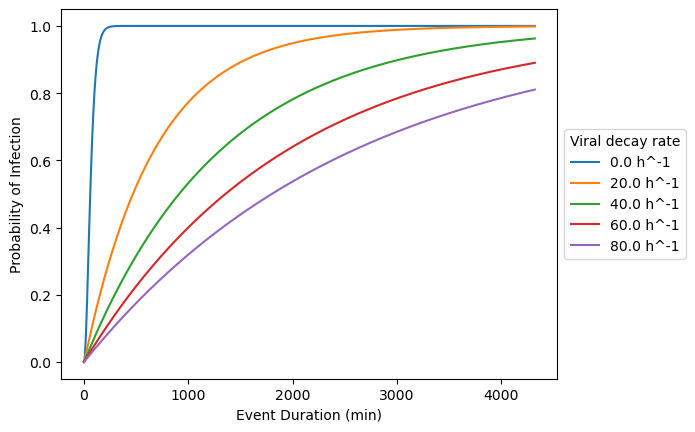

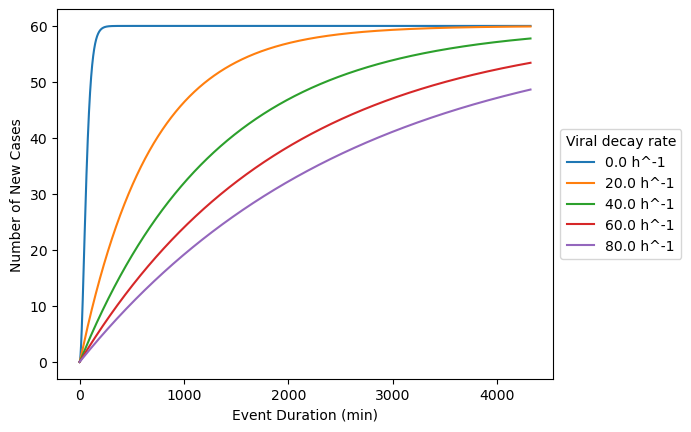

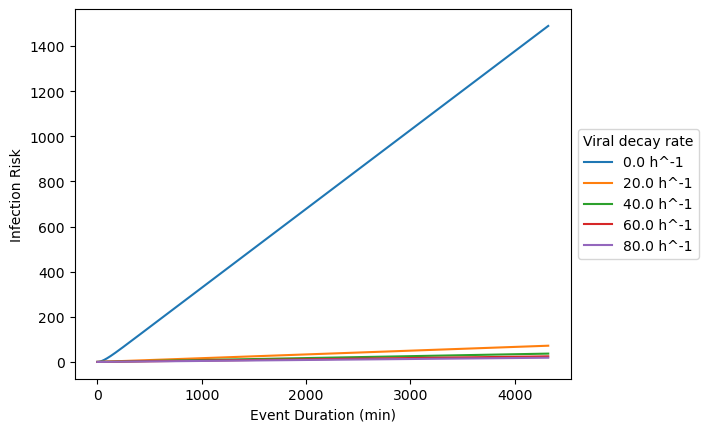

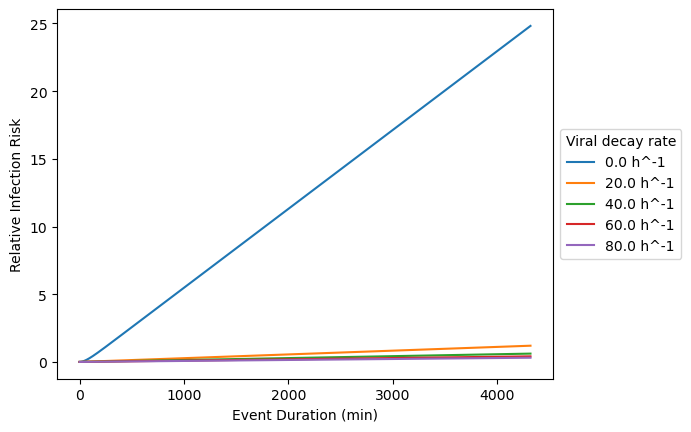

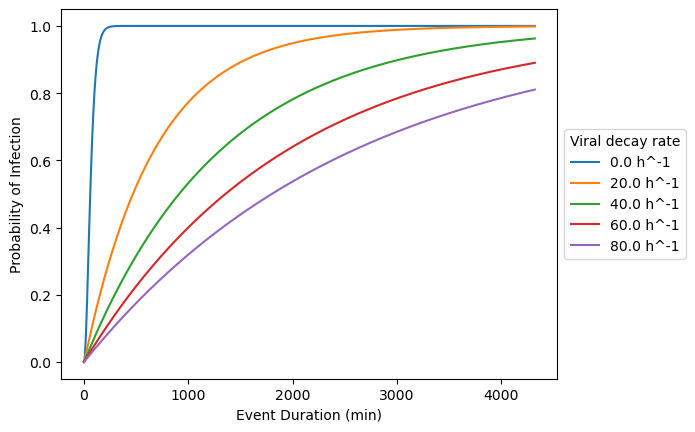

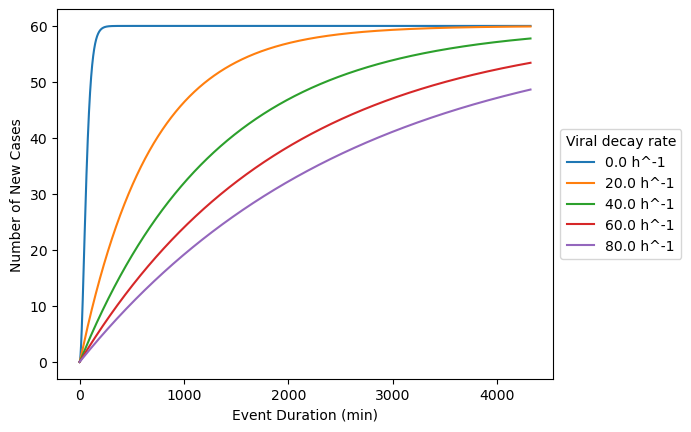

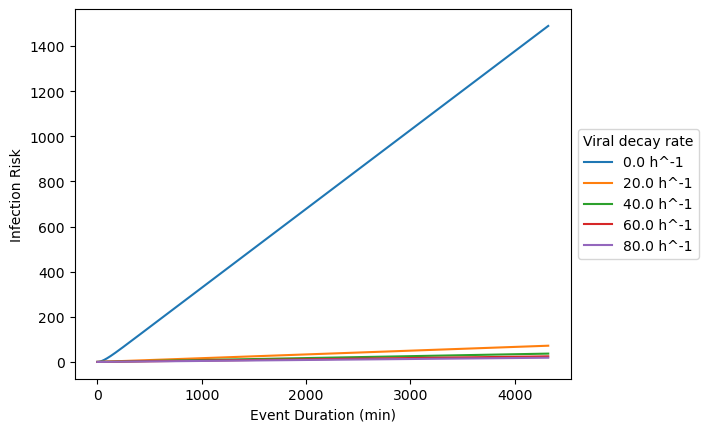

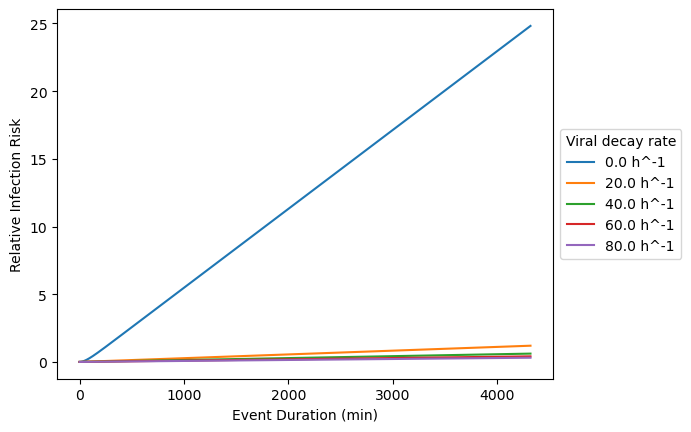

In [27]:
eventDuration_minss = np.arange(0,72*60,step = .1)
virusDecayRates = np.arange(0.00,100.00, step = 20)

# reset masking params
inhalationMaskEfficiency = 0 
inhalationMaskEfficiency = 0 
propPeopleWithMasks = 0 

netEmissionRates = np.zeros_like(eventDuration_minss)
avgQuantaConcentrations = np.zeros_like(eventDuration_minss)
quantaInhaledPerPersons = np.zeros_like(eventDuration_minss)
probOfInfs = np.zeros_like(eventDuration_minss)
numNewCasess = np.zeros_like(eventDuration_minss)
infRiskParams = np.zeros_like(eventDuration_minss)
relInfRiskParams = np.zeros_like(eventDuration_minss)

# fig1, ax1 = plt.subplots(1)
# fig2, ax2 = plt.subplots(1)
fig3, ax3 = plt.subplots(1)
fig4, ax4 = plt.subplots(1)
fig5, ax5 = plt.subplots(1)
fig6, ax6 = plt.subplots(1)


for j in range(len(virusDecayRates)):
    for i in range(len(eventDuration_minss)):
        ventilations = ventilationRate, virusDecayRates[j], depositionRate, additionalControlMeasureRate 
        eventParamss = eventDuration_minss[i], eventRepetitions
        netEmissionRates[i], avgQuantaConcentrations[i], quantaInhaledPerPersons[i], probOfInfs[i], numNewCasess[i], infRiskParams[i], relInfRiskParams[i] = main(
                roomParams, envParams, occupants, eventParamss, breathParams, enhancements, masking, ventilations, pathogenParams)

#     ax1.plot(eventDuration_minss, avgQuantaConcentrations, label = round(virusDecayRates[j],2))
#     ax1.plot(eventDuration_mins, avgQuantaConcentration, 'ro', label='Skagit Chorale')
#     ax1.set_xlabel('Event Duration (min)')
#     ax1.set_ylabel('avgQuantaConcentrations')
#     ax1.legend()

#     ax2.plot(eventDuration_minss, quantaInhaledPerPersons, label=round(virusDecayRates[j],2))
#     ax2.plot(eventDuration_mins, quantaInhaledPerPerson, 'ro', label='Skagit Chorale')
#     ax2.set_xlabel('Event Duration (min)')
#     ax2.set_ylabel('quantaInhaledPerPersons')
#     ax2.legend()

    ax3.plot(eventDuration_minss, probOfInfs, label="{} h^-1".format(round(virusDecayRates[j],2)))
    ax3.set_xlabel('Event Duration (min)')
    ax3.set_ylabel('Probability of Infection')
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax3.get_legend().set_title("Viral decay rate")


    ax4.plot(eventDuration_minss, numNewCasess, label="{} h^-1".format(round(virusDecayRates[j],2)))
    ax4.set_xlabel('Event Duration (min)')
    ax4.set_ylabel('Number of New Cases')
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax4.get_legend().set_title("Viral decay rate")

    ax5.plot(eventDuration_minss, infRiskParams, label="{} h^-1".format(round(virusDecayRates[j],2)))
    ax5.set_xlabel('Event Duration (min)')
    ax5.set_ylabel('Infection Risk')
    ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax5.get_legend().set_title("Viral decay rate")

    ax6.plot(eventDuration_minss, relInfRiskParams, label="{} h^-1".format(round(virusDecayRates[j],2)))
    ax6.set_xlabel('Event Duration (min)')
    ax6.set_ylabel('Relative Infection Risk')
    ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax6.get_legend().set_title("Viral decay rate")

# display(fig1)
# display(fig2)
display(fig3)
display(fig4)
display(fig5)
display(fig6)



#### Ventilation

/var/folders/15/s8ldr64x50q5znqbr6dxz1tc0000gp/T/ipykernel_30499/1845653639.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  avgQuantaConcentration = netEmissionRate/firstOrderLossRate/volumeRoom*(1-(1/firstOrderLossRate/eventDuration)*(1-np.exp(-firstOrderLossRate*eventDuration))) # infectious doses (quanta) m-3
/var/folders/15/s8ldr64x50q5znqbr6dxz1tc0000gp/T/ipykernel_30499/1845653639.py:6: RuntimeWarning: invalid value encountered in scalar multiply
  avgQuantaConcentration = netEmissionRate/firstOrderLossRate/volumeRoom*(1-(1/firstOrderLossRate/eventDuration)*(1-np.exp(-firstOrderLossRate*eventDuration))) # infectious doses (quanta) m-3
/var/folders/15/s8ldr64x50q5znqbr6dxz1tc0000gp/T/ipykernel_30499/1845653639.py:25: RuntimeWarning: invalid value encountered in scalar divide
  infRiskParam = relBreathingRateFactor * vocalEnhancement * (1-exhalationMaskEfficiency*propPeopleWithMasks)*(1-propPeopleWithMasks*inhalationMaskEfficiency)*eventDuration*S_0/(firstOrderL

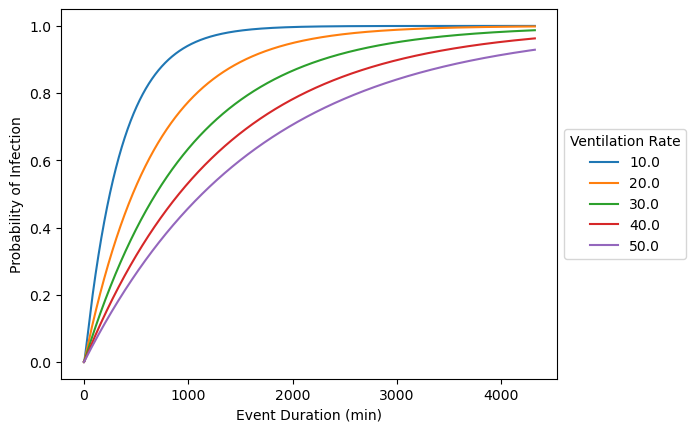

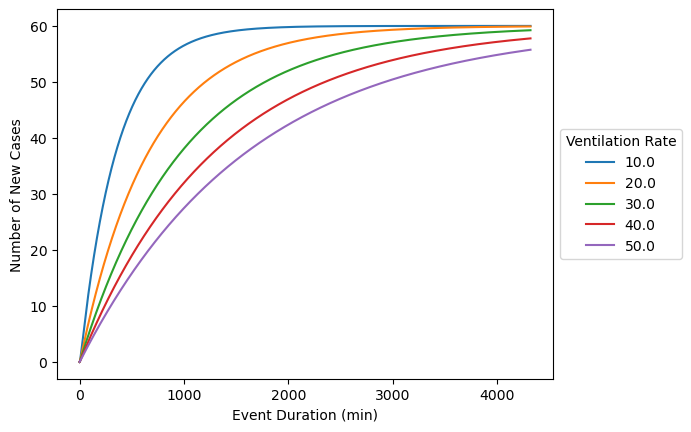

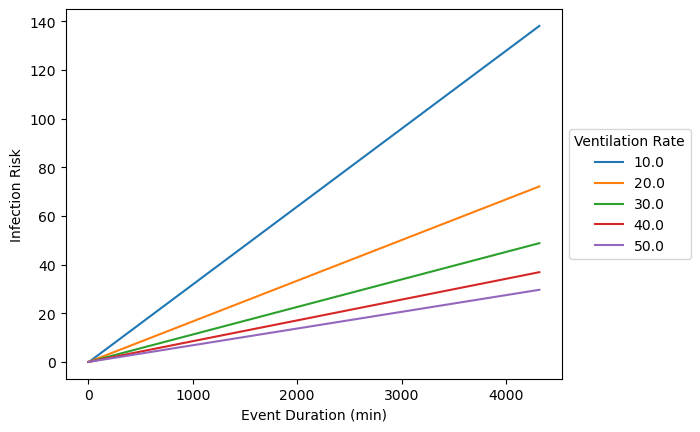

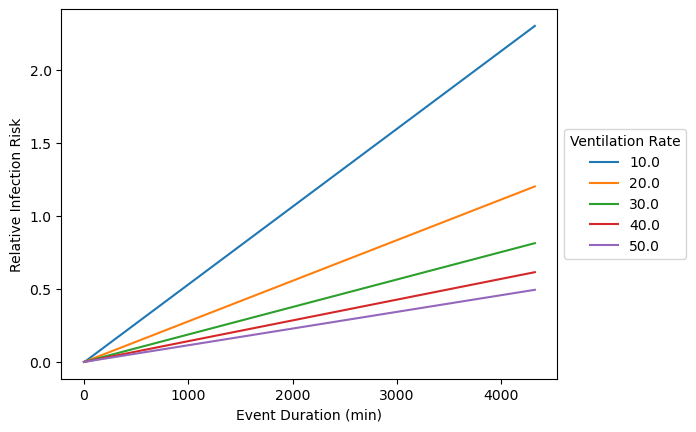

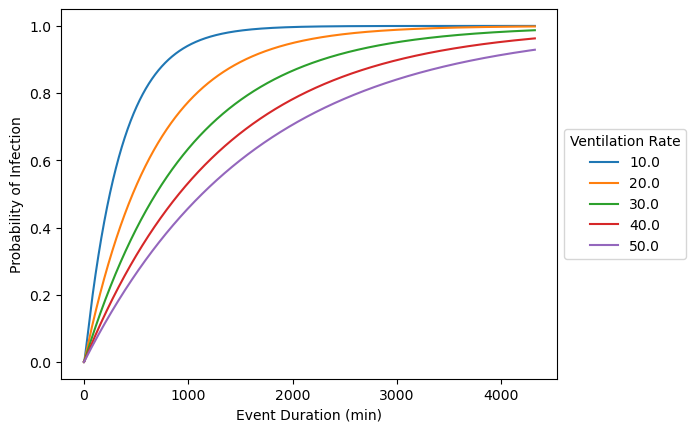

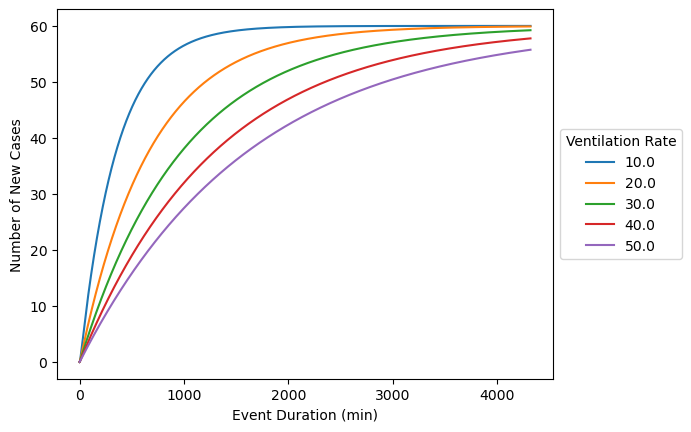

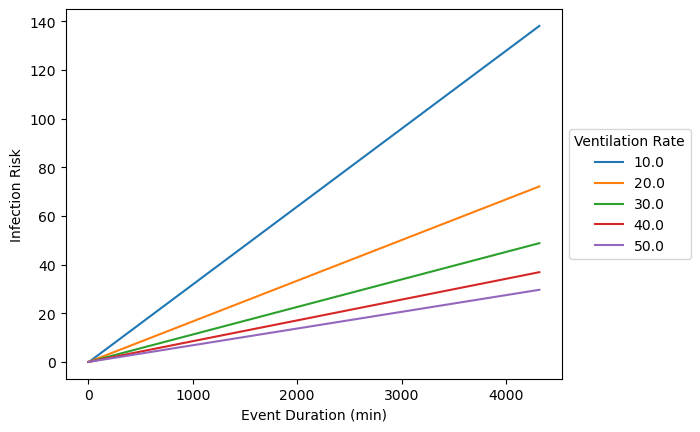

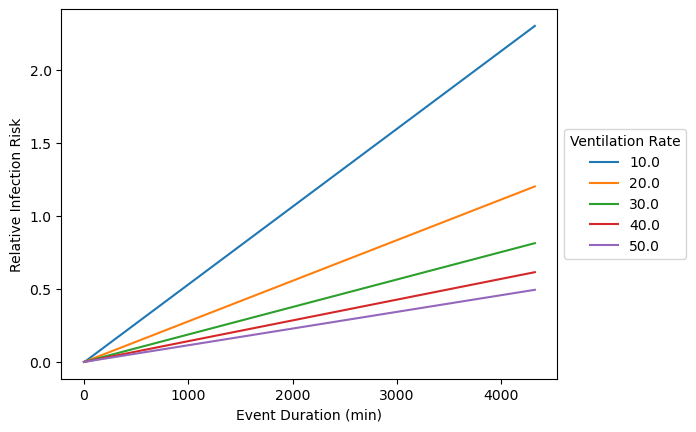

In [28]:
eventDuration_minss = np.arange(0,72*60,step = .1)
ventilationRates = np.arange(10.,51,step = 10)

netEmissionRates = np.zeros_like(eventDuration_minss)
avgQuantaConcentrations = np.zeros_like(eventDuration_minss)
quantaInhaledPerPersons = np.zeros_like(eventDuration_minss)
probOfInfs = np.zeros_like(eventDuration_minss)
numNewCasess = np.zeros_like(eventDuration_minss)
infRiskParams = np.zeros_like(eventDuration_minss)
relInfRiskParams = np.zeros_like(eventDuration_minss)

# fig1, ax1 = plt.subplots(1)
# fig2, ax2 = plt.subplots(1)
fig3, ax3 = plt.subplots(1)
fig4, ax4 = plt.subplots(1)
fig5, ax5 = plt.subplots(1)
fig6, ax6 = plt.subplots(1)


for j in range(len(ventilationRates)):
    for i in range(len(eventDuration_minss)):
        ventilations = ventilationRates[j], virusDecayRate, depositionRate, additionalControlMeasureRate 
        eventParamss = eventDuration_minss[i], eventRepetitions
        netEmissionRates[i], avgQuantaConcentrations[i], quantaInhaledPerPersons[i], probOfInfs[i], numNewCasess[i], infRiskParams[i], relInfRiskParams[i] = main(
                roomParams, envParams, occupants, eventParamss, breathParams, enhancements, masking, ventilations, pathogenParams)

#     ax1.plot(eventDuration_minss, avgQuantaConcentrations, label = round(ventilationRates[j],2))
#     ax1.plot(eventDuration_mins, avgQuantaConcentration, 'ro', label='Skagit Chorale')
#     ax1.set_xlabel('Event Duration (min)')
#     ax1.set_ylabel('avgQuantaConcentrations')
#     ax1.legend()

#     ax2.plot(eventDuration_minss, quantaInhaledPerPersons, label=round(ventilationRates[j],2))
#     ax2.plot(eventDuration_mins, quantaInhaledPerPerson, 'ro', label='Skagit Chorale')
#     ax2.set_xlabel('Event Duration (min)')
#     ax2.set_ylabel('quantaInhaledPerPersons')
#     ax2.legend()

    ax3.plot(eventDuration_minss, probOfInfs, label=round(ventilationRates[j],2))
    ax3.set_xlabel('Event Duration (min)')
    ax3.set_ylabel('Probability of Infection')
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax3.get_legend().set_title("Ventilation Rate")

    ax4.plot(eventDuration_minss, numNewCasess, label=round(ventilationRates[j],2))
    ax4.set_xlabel('Event Duration (min)')
    ax4.set_ylabel('Number of New Cases')
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax4.get_legend().set_title("Ventilation Rate")

    ax5.plot(eventDuration_minss, infRiskParams, label=round(ventilationRates[j],2))
    ax5.set_xlabel('Event Duration (min)')
    ax5.set_ylabel('Infection Risk')
    ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax5.get_legend().set_title("Ventilation Rate")

    ax6.plot(eventDuration_minss, relInfRiskParams, label=round(ventilationRates[j],2))
    ax6.set_xlabel('Event Duration (min)')
    ax6.set_ylabel('Relative Infection Risk')
    ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax6.get_legend().set_title("Ventilation Rate")

# display(fig1)
# display(fig2)
display(fig3)
display(fig4)
display(fig5)
display(fig6)



#### Quanta

/var/folders/15/s8ldr64x50q5znqbr6dxz1tc0000gp/T/ipykernel_30499/1845653639.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  avgQuantaConcentration = netEmissionRate/firstOrderLossRate/volumeRoom*(1-(1/firstOrderLossRate/eventDuration)*(1-np.exp(-firstOrderLossRate*eventDuration))) # infectious doses (quanta) m-3
/var/folders/15/s8ldr64x50q5znqbr6dxz1tc0000gp/T/ipykernel_30499/1845653639.py:6: RuntimeWarning: invalid value encountered in scalar multiply
  avgQuantaConcentration = netEmissionRate/firstOrderLossRate/volumeRoom*(1-(1/firstOrderLossRate/eventDuration)*(1-np.exp(-firstOrderLossRate*eventDuration))) # infectious doses (quanta) m-3
/var/folders/15/s8ldr64x50q5znqbr6dxz1tc0000gp/T/ipykernel_30499/1845653639.py:25: RuntimeWarning: invalid value encountered in scalar divide
  infRiskParam = relBreathingRateFactor * vocalEnhancement * (1-exhalationMaskEfficiency*propPeopleWithMasks)*(1-propPeopleWithMasks*inhalationMaskEfficiency)*eventDuration*S_0/(firstOrderL

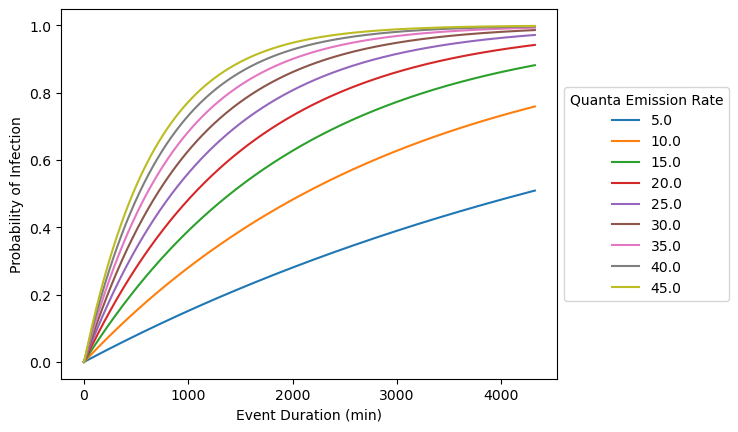

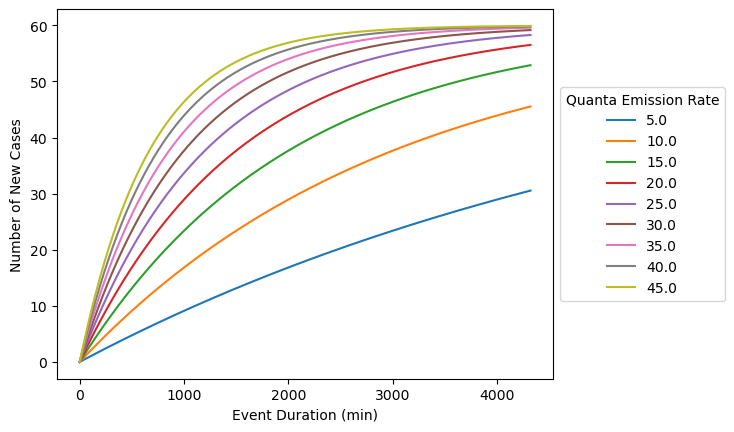

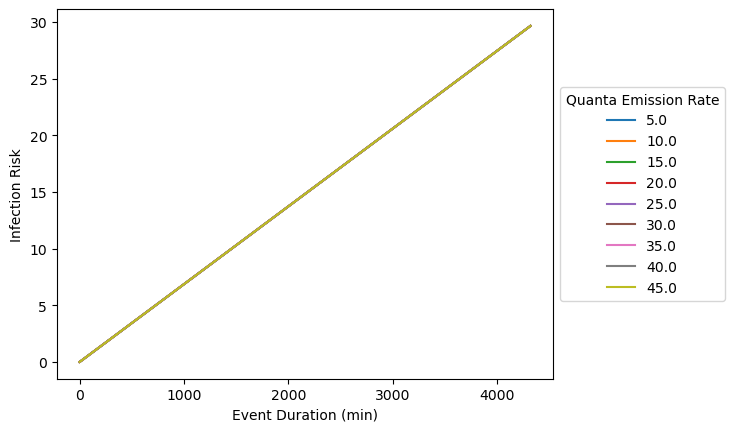

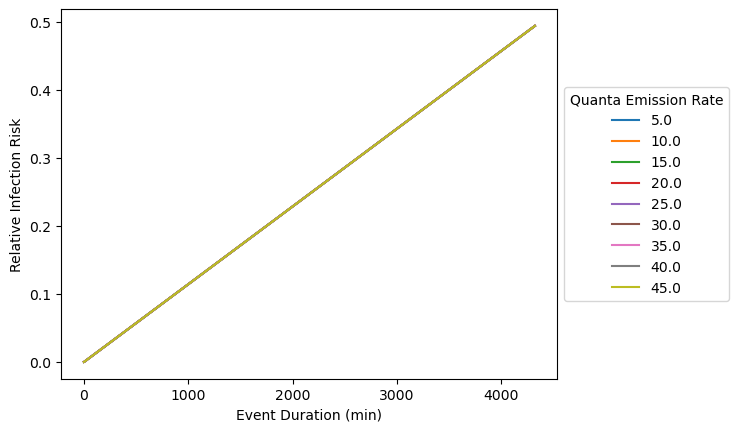

In [29]:
eventDuration_minss = np.arange(0,72*60,step = .1)
quantaExhalationRates = np.arange(5.,50,step = 5)

netEmissionRates = np.zeros_like(eventDuration_minss)
avgQuantaConcentrations = np.zeros_like(eventDuration_minss)
quantaInhaledPerPersons = np.zeros_like(eventDuration_minss)
probOfInfs = np.zeros_like(eventDuration_minss)
numNewCasess = np.zeros_like(eventDuration_minss)
infRiskParams = np.zeros_like(eventDuration_minss)
relInfRiskParams = np.zeros_like(eventDuration_minss)

# fig1, ax1 = plt.subplots(1)
# fig2, ax2 = plt.subplots(1)
fig3, ax3 = plt.subplots(1)
fig4, ax4 = plt.subplots(1)
fig5, ax5 = plt.subplots(1)
fig6, ax6 = plt.subplots(1)


for j in range(len(quantaExhalationRates)):
    for i in range(len(eventDuration_minss)):
        enhancementss = quantaExhalationRates[j], variantEnhancement, vocalEnhancement
        eventParamss = eventDuration_minss[i], eventRepetitions
        netEmissionRates[i], avgQuantaConcentrations[i], quantaInhaledPerPersons[i], probOfInfs[i], numNewCasess[i], infRiskParams[i], relInfRiskParams[i] = main(
                roomParams, envParams, occupants, eventParamss, breathParams, enhancementss, masking, ventilations, pathogenParams)

#     ax1.plot(eventDuration_minss, avgQuantaConcentrations, label = round(ventilationRates[j],2))
#     ax1.plot(eventDuration_mins, avgQuantaConcentration, 'ro', label='Skagit Chorale')
#     ax1.set_xlabel('Event Duration (min)')
#     ax1.set_ylabel('avgQuantaConcentrations')
#     ax1.legend()

#     ax2.plot(eventDuration_minss, quantaInhaledPerPersons, label=round(ventilationRates[j],2))
#     ax2.plot(eventDuration_mins, quantaInhaledPerPerson, 'ro', label='Skagit Chorale')
#     ax2.set_xlabel('Event Duration (min)')
#     ax2.set_ylabel('quantaInhaledPerPersons')
#     ax2.legend()

    ax3.plot(eventDuration_minss, probOfInfs, label=round(quantaExhalationRates[j],2))
    ax3.set_xlabel('Event Duration (min)')
    ax3.set_ylabel('Probability of Infection')
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax3.get_legend().set_title("Quanta Emission Rate")

    ax4.plot(eventDuration_minss, numNewCasess, label=round(quantaExhalationRates[j],2))
    ax4.set_xlabel('Event Duration (min)')
    ax4.set_ylabel('Number of New Cases')
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax4.get_legend().set_title("Quanta Emission Rate")

    ax5.plot(eventDuration_minss, infRiskParams, label=round(quantaExhalationRates[j],2))
    ax5.set_xlabel('Event Duration (min)')
    ax5.set_ylabel('Infection Risk')
    ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax5.get_legend().set_title("Quanta Emission Rate")

    ax6.plot(eventDuration_minss, relInfRiskParams, label=round(quantaExhalationRates[j],2))
    ax6.set_xlabel('Event Duration (min)')
    ax6.set_ylabel('Relative Infection Risk')
    ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax6.get_legend().set_title("Quanta Emission Rate")

# display(fig1)
# display(fig2)
# display(fig3)
# display(fig4)
# display(fig5)
# display(fig6)



/var/folders/15/s8ldr64x50q5znqbr6dxz1tc0000gp/T/ipykernel_30499/1845653639.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  avgQuantaConcentration = netEmissionRate/firstOrderLossRate/volumeRoom*(1-(1/firstOrderLossRate/eventDuration)*(1-np.exp(-firstOrderLossRate*eventDuration))) # infectious doses (quanta) m-3
/var/folders/15/s8ldr64x50q5znqbr6dxz1tc0000gp/T/ipykernel_30499/1845653639.py:6: RuntimeWarning: invalid value encountered in scalar multiply
  avgQuantaConcentration = netEmissionRate/firstOrderLossRate/volumeRoom*(1-(1/firstOrderLossRate/eventDuration)*(1-np.exp(-firstOrderLossRate*eventDuration))) # infectious doses (quanta) m-3
/var/folders/15/s8ldr64x50q5znqbr6dxz1tc0000gp/T/ipykernel_30499/1845653639.py:25: RuntimeWarning: invalid value encountered in scalar divide
  infRiskParam = relBreathingRateFactor * vocalEnhancement * (1-exhalationMaskEfficiency*propPeopleWithMasks)*(1-propPeopleWithMasks*inhalationMaskEfficiency)*eventDuration*S_0/(firstOrderL

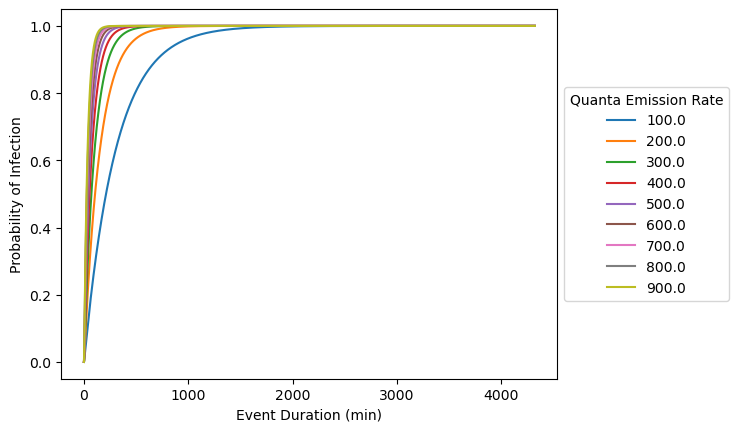

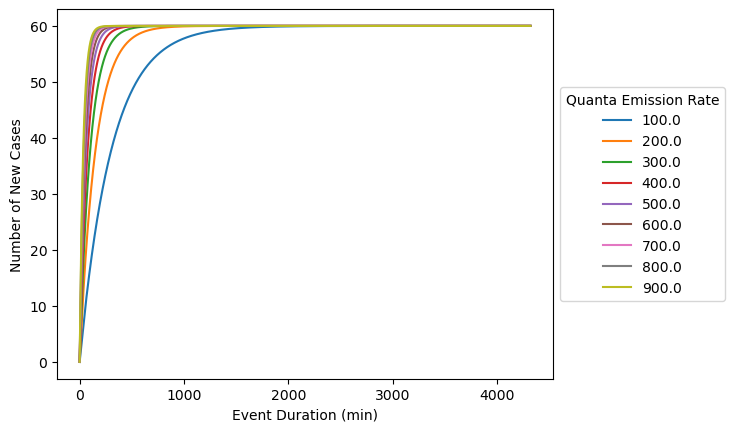

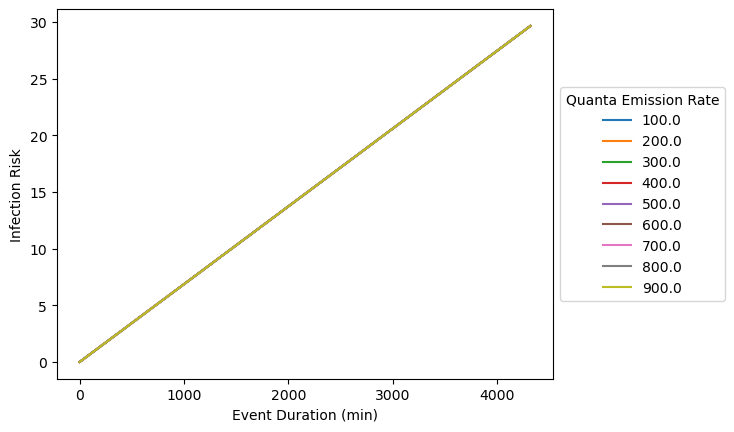

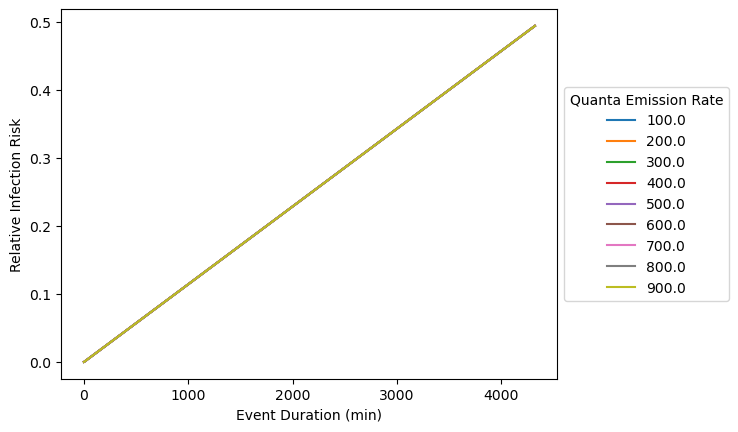

In [30]:
eventDuration_minss = np.arange(0,72*60,step = .1)
quantaExhalationRates = np.arange(100.,1000,step = 100)

netEmissionRates = np.zeros_like(eventDuration_minss)
avgQuantaConcentrations = np.zeros_like(eventDuration_minss)
quantaInhaledPerPersons = np.zeros_like(eventDuration_minss)
probOfInfs = np.zeros_like(eventDuration_minss)
numNewCasess = np.zeros_like(eventDuration_minss)
infRiskParams = np.zeros_like(eventDuration_minss)
relInfRiskParams = np.zeros_like(eventDuration_minss)

# fig1, ax1 = plt.subplots(1)
# fig2, ax2 = plt.subplots(1)
fig3, ax3 = plt.subplots(1)
fig4, ax4 = plt.subplots(1)
fig5, ax5 = plt.subplots(1)
fig6, ax6 = plt.subplots(1)


for j in range(len(quantaExhalationRates)):
    for i in range(len(eventDuration_minss)):
        enhancementss = quantaExhalationRates[j], variantEnhancement, vocalEnhancement
        eventParamss = eventDuration_minss[i], eventRepetitions
        netEmissionRates[i], avgQuantaConcentrations[i], quantaInhaledPerPersons[i], probOfInfs[i], numNewCasess[i], infRiskParams[i], relInfRiskParams[i] = main(
                roomParams, envParams, occupants, eventParamss, breathParams, enhancementss, masking, ventilations, pathogenParams)

#     ax1.plot(eventDuration_minss, avgQuantaConcentrations, label = round(ventilationRates[j],2))
#     ax1.plot(eventDuration_mins, avgQuantaConcentration, 'ro', label='Skagit Chorale')
#     ax1.set_xlabel('Event Duration (min)')
#     ax1.set_ylabel('avgQuantaConcentrations')
#     ax1.legend()

#     ax2.plot(eventDuration_minss, quantaInhaledPerPersons, label=round(ventilationRates[j],2))
#     ax2.plot(eventDuration_mins, quantaInhaledPerPerson, 'ro', label='Skagit Chorale')
#     ax2.set_xlabel('Event Duration (min)')
#     ax2.set_ylabel('quantaInhaledPerPersons')
#     ax2.legend()

    ax3.plot(eventDuration_minss, probOfInfs, label=round(quantaExhalationRates[j],2))
    ax3.set_xlabel('Event Duration (min)')
    ax3.set_ylabel('Probability of Infection')
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax3.get_legend().set_title("Quanta Emission Rate")

    ax4.plot(eventDuration_minss, numNewCasess, label=round(quantaExhalationRates[j],2))
    ax4.set_xlabel('Event Duration (min)')
    ax4.set_ylabel('Number of New Cases')
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax4.get_legend().set_title("Quanta Emission Rate")

    ax5.plot(eventDuration_minss, infRiskParams, label=round(quantaExhalationRates[j],2))
    ax5.set_xlabel('Event Duration (min)')
    ax5.set_ylabel('Infection Risk')
    ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax5.get_legend().set_title("Quanta Emission Rate")

    ax6.plot(eventDuration_minss, relInfRiskParams, label=round(quantaExhalationRates[j],2))
    ax6.set_xlabel('Event Duration (min)')
    ax6.set_ylabel('Relative Infection Risk')
    ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax6.get_legend().set_title("Quanta Emission Rate")

# display(fig1)
# display(fig2)
# display(fig3)
# display(fig4)
# display(fig5)
# display(fig6)

